# Predictive Model w/ Segmentation

## Setup

In [23]:
import pandas as pd
import pysam
import numpy as np
import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import sqlite3
import csv
import glob
import gffpandas.gffpandas as gffpd
from intervaltree import Interval, IntervalTree
import bisect
from tqdm import tqdm
from biomart import BiomartServer
import os
import re
import gseapy as gp
from gseapy.plot import barplot, dotplot
from gseapy import GSEA
import statsmodels.api as sm
import statsmodels.stats.multitest as smm
from scipy.stats import kruskal, mannwhitneyu, ttest_ind, f_oneway, wilcoxon, ranksums, fisher_exact, chi2_contingency, entropy, pearsonr, zscore
import json
import ast
import itertools
import sys
from venn import venn
import contextlib
from imblearn.over_sampling import SMOTE
from upsetplot import from_contents, plot
import warnings
from sklearn.manifold import TSNE
from statsmodels.stats.multitest import multipletests
import shap
import pyranges as pr
from joblib import dump

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import DBSCAN

import importlib
import helper_functions

In [80]:
importlib.reload(helper_functions)
from helper_functions import *

# Initialize JavaScript environment
shap.initjs()

### Data Import

#### Metadata

In [25]:
metadata = pd.read_csv("/data/lvisser/metadata/ont_metadata.csv", sep = ",")
print(metadata.shape)
metadata.head()

(48, 16)


,run_id_rnaseq,run_id_ont,source_directory,sample_id_ori,sample_id_adj,sample_id_adj_rnaseq,cell_line_long,cell_line_short,tumor_type,bio_replicate,Group,L,batch,gender,age (months),barcode
0,RIMR14nov_R3_EKRN230005052.1A_HNYCWDSX5_L1_norRNA,OHMX20230016R_002,data_OHMX20230016R_20231114,RIMR14nov_R3,IMR14nov_R1,IMR14nov_R1,IMR-32,IMR,NB,1,S,L1,14/11/2024,male,13.0,barcode02
1,RIMR21nov_R3_EKRN230005053.1A_HNYCWDSX5_L1_norRNA,NaN,data_OHMX20230016R_NB2,RIMR21nov_R3,IMR21nov_R2,IMR21nov_R2,IMR-32,IMR,NB,2,S,L1,21/11/2024,male,13.0,NaN
2,RIMR12dec_R3_EKRN230005054.1A_HNYCWDSX5_L1_norRNA,NaN,NaN,RIMR12dec_R3,IMR12dec_R3,NaN,IMR-32,IMR,NB,3,S,L1,12/12/2024,male,13.0,NaN
3,RIMR15dec_R3_EKRN230005055.1A_HNYCWDSX5_L1_norRNA,NaN,NaN,RIMR15dec_R3,IMR15dec_R4,NaN,IMR-32,IMR,NB,4,S,L1,15/12/2024,male,13.0,NaN
4,RSHP14nov_R1_EKRN230005048.1A_HNYCWDSX5_L1_norRNA,NaN,NaN,RSHP14nov_R1,SHP14nov_R1,NaN,SH-EP,SHP,NB,1,S,L1,14/11/2024,female,48.0,NaN


#### Gene Whitelist

In [26]:
whitelist = pd.read_csv("/data/lvisser/ferroptosis_gene_whitelists/complete_gene_list_no_duplicates.txt", index_col = 0)
whitelist.columns = ["gene_symbol"]
print(whitelist.shape)
whitelist.head()

(1271, 1)


,gene_symbol
1,NR4A1
2,NR4A2
3,NR4A3
4,ACACA
5,ACLY


#### DE Genes

In [27]:
DEG_full = pd.read_csv("/data/lvisser/DE_genes/DE_results_human_Group_R_S_full.csv")
DEG_full = DEG_full[DEG_full["padj"] < 0.05]
DEG_full = DEG_full.rename(columns = {DEG_full.columns[0]: "Gene", "name": "gene_symbol"}).reset_index(drop = True).sort_values("gene_symbol")
print(DEG_full.shape)
DEG_full.head()

(8488, 51)


,Gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,IMR14nov_R1,SHY2sept_R1,SKN10nov_R1,SHP14nov_R1,...,SH-SY5Y_C1,SH-SY5Y_J2,SH-SY5Y_J4,SH-SY5Y_C4,SH-SY5Y_J3,SH-SY5Y_J1,SH-SY5Y_C3,gene_symbol,type,description
6191,ENSG00000268895,109.118613,1.231726,0.705169,2.781499e-03,0.014594,198.323394,91.560461,165.733760,149.289871,...,64.677340,147.940128,124.847573,63.303751,144.163675,132.674599,84.841380,A1BG-AS1,lncRNA,A1BG antisense RNA 1 [Source:HGNC Symbol;Acc:H...
1837,ENSG00000128274,186.925118,-4.550350,1.181914,1.108199e-06,0.000020,0.922434,0.000000,3.682972,1154.084822,...,1.043183,0.000000,0.000000,0.000000,0.000000,2.567895,0.000000,A4GALT,protein_coding,"alpha 1,4-galactosyltransferase (P blood group..."
4357,ENSG00000242908,8.323454,-3.936345,2.903493,4.346391e-04,0.003240,0.000000,0.000000,0.000000,95.291407,...,0.000000,0.000000,0.000000,1.055063,0.000000,0.855965,0.000000,AADACL2-AS1,lncRNA,AADACL2 antisense RNA 1 [Source:HGNC Symbol;Ac...
1568,ENSG00000129673,25.946025,-1.413103,0.318514,3.030699e-07,0.000006,95.933177,6.104031,17.187205,10.587934,...,5.215914,3.735862,2.496951,10.550625,4.219425,2.567895,5.953781,AANAT,protein_coding,aralkylamine N-acetyltransferase [Source:HGNC ...
1479,ENSG00000008311,818.446853,-1.918062,0.400305,2.025127e-07,0.000004,1191.785231,79.352400,214.840059,4884.214022,...,126.225131,279.442464,342.082349,136.103064,341.070157,273.908850,167.450093,AASS,protein_coding,aminoadipate-semialdehyde synthase [Source:HGN...


In [28]:
DEG_MM = pd.read_csv("/data/lvisser/DE_genes/DE_results_human_Group_R_S_MM.csv")
DEG_MM = DEG_MM[DEG_MM["padj"] < 0.05]
DEG_MM = DEG_MM.rename(columns = {DEG_MM.columns[0]: "Gene", "name": "gene_symbol"}).reset_index(drop = True).sort_values("gene_symbol")
print(DEG_MM.shape)
DEG_MM.head()

(10513, 25)


,Gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,RPMI8226_1_3b,JJN3_1_3b,OPM_4_1,MM1R_1_2,...,MM1R_3_1,MM1R_2_2,RPMI8226_2_3b,JJN3_2_2b,JJN3_3_3b,RPMI8226_3_2b,MM1R_4_2,gene_symbol,type,description
1400,ENSG00000121410,7.014971,5.552054,0.881142,3.236431e-11,6.644271e-10,30.772996,4.387573,0.000000,0.727842,...,0.000000,0.000000,4.439469,19.874979,18.699434,10.235900,0.000000,A1BG,protein_coding,alpha-1-B glycoprotein [Source:HGNC Symbol;Acc...
179,ENSG00000268895,53.074171,8.849115,0.774549,3.377764e-32,5.397292e-30,121.553335,73.711227,0.000000,0.000000,...,0.000000,0.000000,71.031509,177.284812,113.009624,79.693789,0.000000,A1BG-AS1,lncRNA,A1BG antisense RNA 1 [Source:HGNC Symbol;Acc:H...
8748,ENSG00000148584,4.744162,1.489638,0.896618,6.471468e-03,2.127470e-02,0.769325,6.142602,1.625325,0.000000,...,5.721027,0.823753,16.648010,3.974996,4.878113,21.934070,1.828777,A1CF,protein_coding,APOBEC1 complementation factor [Source:HGNC Sy...
9793,ENSG00000175899,2.744737,-1.904452,1.547904,1.234374e-02,3.624637e-02,0.000000,0.000000,0.812662,9.461943,...,17.163082,9.885031,0.000000,3.179997,0.000000,0.000000,1.828777,A2M,protein_coding,alpha-2-macroglobulin [Source:HGNC Symbol;Acc:...
8567,ENSG00000128274,196.668642,2.250318,1.534502,5.737457e-03,1.926012e-02,748.553130,7.897631,0.000000,53.132449,...,75.326858,46.953897,9.988806,704.369253,703.261329,12.429307,47.548195,A4GALT,protein_coding,"alpha 1,4-galactosyltransferase (P blood group..."


In [29]:
DEG_NB = pd.read_csv("/data/lvisser/DE_genes/DE_results_human_Group_R_S_NB.csv")
DEG_NB = DEG_NB[DEG_NB["padj"] < 0.05]
DEG_NB = DEG_NB.rename(columns = {DEG_NB.columns[0]: "Gene", "name": "gene_symbol"}).reset_index(drop = True).sort_values("gene_symbol")
print(DEG_NB.shape)
DEG_NB.head()

(8362, 35)


,Gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,IMR14nov_R1,SHY2sept_R1,SKN10nov_R1,SHP14nov_R1,...,SH-SY5Y_C1,SH-SY5Y_J2,SH-SY5Y_J4,SH-SY5Y_C4,SH-SY5Y_J3,SH-SY5Y_J1,SH-SY5Y_C3,gene_symbol,type,description
5338,ENSG00000121410,43.403148,-0.703134,0.282696,1.270573e-03,7.467374e-03,99.622914,20.346769,33.146752,41.292943,...,13.561378,38.105791,26.217990,18.991125,42.194246,29.958781,33.490019,A1BG,protein_coding,alpha-1-B glycoprotein [Source:HGNC Symbol;Acc...
3589,ENSG00000175899,10.902600,2.421982,0.806641,9.738070e-05,8.514165e-04,5.534606,18.312092,1.227657,1.058793,...,33.381853,23.162343,11.236282,13.715813,21.800361,20.543164,32.745796,A2M,protein_coding,alpha-2-macroglobulin [Source:HGNC Symbol;Acc:...
6417,ENSG00000256069,3.489697,1.528053,0.946759,3.738377e-03,1.828207e-02,0.000000,3.052015,1.227657,4.235174,...,1.043183,2.241517,4.993903,6.330375,5.625899,5.991756,4.465336,A2MP1,transcribed_unprocessed_pseudogene,alpha-2-macroglobulin pseudogene 1 [Source:HGN...
841,ENSG00000128274,180.929104,-7.278222,1.117654,3.352751e-12,1.246874e-10,0.922434,0.000000,3.682972,1154.084822,...,1.043183,0.000000,0.000000,0.000000,0.000000,2.567895,0.000000,A4GALT,protein_coding,"alpha 1,4-galactosyltransferase (P blood group..."
5986,ENSG00000242908,13.445579,-3.317788,2.683701,2.529103e-03,1.325931e-02,0.000000,0.000000,0.000000,95.291407,...,0.000000,0.000000,0.000000,1.055063,0.000000,0.855965,0.000000,AADACL2-AS1,lncRNA,AADACL2 antisense RNA 1 [Source:HGNC Symbol;Ac...


## Segmentations

### Promotor Regions (Ensembl Regulatory Features GFF)

In [30]:
gff_file = "/data/lvisser/Ensembl/homo_sapiens.GRCh38.Regulatory_Build.regulatory_features.20210107.gff"

rf = gffpd.read_gff3(gff_file)
rf_df = pd.DataFrame(rf.df)

subattributes = rf_df['attributes'].str.split(';', expand=True)

for i in range(subattributes.shape[1]):
    subattribute = subattributes[i].str.split('=', expand=True)
    rf_df[subattribute[0].iloc[0]] = subattribute[1]

rf_df = rf_df.drop('attributes', axis = 1)

rf_df.to_csv('segmentations/all_rf_grch38.csv', index=False)
rf_df.head()

/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/gffpandas/gffpandas.py:32: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_table(self._gff_file, comment='#',


,seq_id,source,type,start,end,score,strand,phase,ID,bound_end,bound_start,description,feature_type
0,GL000008.2,Regulatory_Build,open_chromatin_region,103733,104006,.,.,.,open_chromatin_region:ENSR00000898744,104006,103733,Open chromatin region,Open chromatin
1,GL000008.2,Regulatory_Build,open_chromatin_region,106249,106503,.,.,.,open_chromatin_region:ENSR00000898745,106503,106249,Open chromatin region,Open chromatin
2,GL000008.2,Regulatory_Build,open_chromatin_region,112878,113287,.,.,.,open_chromatin_region:ENSR00000898746,113287,112878,Open chromatin region,Open chromatin
3,GL000008.2,Regulatory_Build,open_chromatin_region,134012,134308,.,.,.,open_chromatin_region:ENSR00000898747,134308,134012,Open chromatin region,Open chromatin
4,GL000008.2,Regulatory_Build,open_chromatin_region,138112,138274,.,.,.,open_chromatin_region:ENSR00001290160,138274,138112,Open chromatin region,Open chromatin


In [31]:
grch38 = pd.read_csv('/data/lvisser/Ensembl/GRCh38.tsv', sep='\t', header = None)
grch38.columns = ["chrom", "total_length(bp)", "GenBank_accession", "RefSeq_accession"]
grch38.head()

,chrom,total_length(bp),GenBank_accession,RefSeq_accession
0,1,"248,956,422",CM000663.2,NC_000001.11
1,2,"242,193,529",CM000664.2,NC_000002.12
2,3,"198,295,559",CM000665.2,NC_000003.12
3,4,"190,214,555",CM000666.2,NC_000004.12
4,5,"181,538,259",CM000667.2,NC_000005.10


In [32]:
# Replace 'file.sga' with the path to your SGA file
epd_df = pd.read_csv('/data/lvisser/EPD/Hs_EPDnew.sga', sep='\t')
epd_df.columns = ["RefSeq_accession", "type", "position", "strand", "idk", "promotorID"]
epd_df = epd_df.merge(grch38[["chrom", "RefSeq_accession"]], on = "RefSeq_accession", how = "left")
epd_df["gene_symbol"] = epd_df["promotorID"].str.split("_", expand = True)[0]
epd_df["chrom"] = "chr" + epd_df["chrom"].astype(str)

# Print the first few rows of the DataFrame
print(epd_df.shape)
epd_df.head()

(29597, 8)


,RefSeq_accession,type,position,strand,idk,promotorID,chrom,gene_symbol
0,NC_000001.11,TSS,960633,+,1,KLHL17_1,chr1,KLHL17
1,NC_000001.11,TSS,966482,+,1,PLEKHN1_1,chr1,PLEKHN1
2,NC_000001.11,TSS,976681,-,1,PERM1_1,chr1,PERM1
3,NC_000001.11,TSS,1000097,-,1,HES4_1,chr1,HES4
4,NC_000001.11,TSS,1000511,+,1,ISG15_2,chr1,ISG15


In [33]:
rf_promotors = rf_df[rf_df['type'] == 'promoter'].copy()
rf_promotors['seq_id'] = "chr" + rf_promotors['seq_id'].astype(str)
rf_promotors = rf_promotors.rename(columns = {"seq_id": "chrom"})
rf_promotors['segment_id'] = rf_promotors['chrom'].astype(str) + ':' + rf_promotors['start'].astype(str) + '-' + rf_promotors['end'].astype(str)
rf_promotors['region'] = pd.IntervalIndex.from_arrays(rf_promotors['start'], rf_promotors['end'], closed='both')
rf_promotors["length"] = rf_promotors["end"] - rf_promotors["start"]

rf_promotors.to_csv("/data/lvisser/segmentations/rf_promotors_grch38.csv", index=False)

grouped = rf_promotors.groupby('chrom')

# Create an IntervalTree for each group
promotor_trees = {str(seq_id): IntervalTree(Interval(row.start, row.end, row.segment_id) for row in group.itertuples()) for seq_id, group in grouped}

# Convert rf_promotors to a dictionary for faster lookups
rf_promotors_dict = rf_promotors.set_index('segment_id').to_dict('index')

rf_promotors_genes_list = []

for chrom in epd_df["chrom"].unique():
    epd_df_slice = epd_df[epd_df["chrom"] == chrom]
    tree = promotor_trees[chrom]
    for row in epd_df_slice.itertuples():
        intervals = tree[row.position]
        for interval in intervals:
            new_row = rf_promotors_dict[interval.data].copy()
            new_row["segment_id"] = interval.data  # Add 'segment_id' to the new row
            new_row["gene_symbol"] = row.gene_symbol
            rf_promotors_genes_list.append(new_row)

rf_promotors_genes = pd.DataFrame(rf_promotors_genes_list)
rf_promotors_genes = rf_promotors_genes.drop_duplicates()

rf_promotors_genes.to_csv("/data/lvisser/segmentations/rf_promotors_genes.csv", index=False)

In [34]:
rf_promotors_genes = pd.read_csv('/data/lvisser/segmentations/rf_promotors_genes.csv')
print(rf_promotors_genes.shape)
rf_promotors_genes.head()

(16525, 17)


,chrom,source,type,start,end,score,strand,phase,ID,bound_end,bound_start,description,feature_type,region,length,segment_id,gene_symbol
0,chr1,Regulatory_Build,promoter,957600,962001,.,.,.,promoter:ENSR00000000111,963999,956402,Predicted promoter,Promoter,"[957600, 962001]",4401,chr1:957600-962001,KLHL17
1,chr1,Regulatory_Build,promoter,965800,967601,.,.,.,promoter:ENSR00000000112,968199,965402,Predicted promoter,Promoter,"[965800, 967601]",1801,chr1:965800-967601,PLEKHN1
2,chr1,Regulatory_Build,promoter,975600,977201,.,.,.,promoter:ENSR00000344444,978843,975202,Predicted promoter,Promoter,"[975600, 977201]",1601,chr1:975600-977201,PERM1
3,chr1,Regulatory_Build,promoter,997400,1002401,.,.,.,promoter:ENSR00000000118,1007399,995602,Predicted promoter,Promoter,"[997400, 1002401]",5001,chr1:997400-1002401,HES4
4,chr1,Regulatory_Build,promoter,997400,1002401,.,.,.,promoter:ENSR00000000118,1007399,995602,Predicted promoter,Promoter,"[997400, 1002401]",5001,chr1:997400-1002401,ISG15


In [35]:
rf_promotors_DEG = rf_promotors_genes[rf_promotors_genes["gene_symbol"].isin(DEG_full["gene_symbol"])].drop_duplicates()
rf_promotors_DEG.to_csv('/data/lvisser/segmentations/rf_promotors_DEG.csv', index=False)

In [36]:
rf_promotors_DEG = pd.read_csv('/data/lvisser/segmentations/rf_promotors_DEG.csv')
print(rf_promotors_DEG.shape)
rf_promotors_DEG.head()

(5182, 17)


,chrom,source,type,start,end,score,strand,phase,ID,bound_end,bound_start,description,feature_type,region,length,segment_id,gene_symbol
0,chr1,Regulatory_Build,promoter,957600,962001,.,.,.,promoter:ENSR00000000111,963999,956402,Predicted promoter,Promoter,"[957600, 962001]",4401,chr1:957600-962001,KLHL17
1,chr1,Regulatory_Build,promoter,997400,1002401,.,.,.,promoter:ENSR00000000118,1007399,995602,Predicted promoter,Promoter,"[997400, 1002401]",5001,chr1:997400-1002401,HES4
2,chr1,Regulatory_Build,promoter,1211800,1218201,.,.,.,promoter:ENSR00000344538,1218599,1211002,Predicted promoter,Promoter,"[1211800, 1218201]",6401,chr1:1211800-1218201,TNFRSF4
3,chr1,Regulatory_Build,promoter,1304000,1310601,.,.,.,promoter:ENSR00000344573,1311199,1302402,Predicted promoter,Promoter,"[1304000, 1310601]",6601,chr1:1304000-1310601,ACAP3
4,chr1,Regulatory_Build,promoter,1397800,1401201,.,.,.,promoter:ENSR00000000186,1406599,1397202,Predicted promoter,Promoter,"[1397800, 1401201]",3401,chr1:1397800-1401201,CCNL2


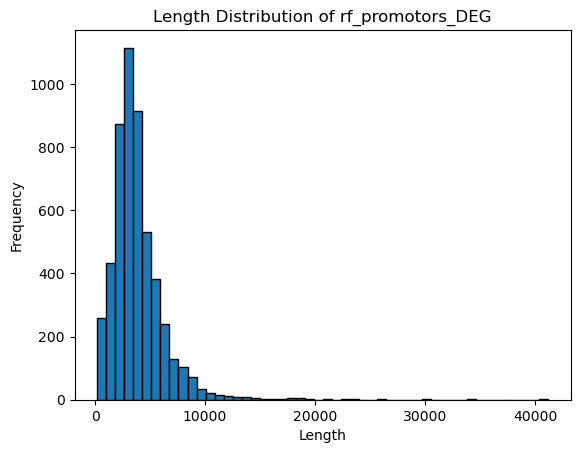

In [37]:
# Assuming 'length' is the column with the lengths
lengths = rf_promotors_DEG['length']

plt.hist(lengths, bins=50, edgecolor='black')
plt.title('Length Distribution of rf_promotors_DEG')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

### Gene Bodies

In [38]:
gene_bodies_df = pd.read_csv("/data/lvisser/Ensembl/gene_bodies_105.txt", sep = "\t", dtype={6: str})
gene_bodies_df.head()

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene start (bp),Gene end (bp),Chromosome/scaffold name,Transcription start site (TSS),Gene name,Gene description
0,ENSG00000210049,ENSG00000210049.1,ENST00000387314,ENST00000387314.1,577,647,MT,577,MT-TF,mitochondrially encoded tRNA-Phe (UUU/C) [Sour...
1,ENSG00000211459,ENSG00000211459.2,ENST00000389680,ENST00000389680.2,648,1601,MT,648,MT-RNR1,mitochondrially encoded 12S rRNA [Source:HGNC ...
2,ENSG00000210077,ENSG00000210077.1,ENST00000387342,ENST00000387342.1,1602,1670,MT,1602,MT-TV,mitochondrially encoded tRNA-Val (GUN) [Source...
3,ENSG00000210082,ENSG00000210082.2,ENST00000387347,ENST00000387347.2,1671,3229,MT,1671,MT-RNR2,mitochondrially encoded 16S rRNA [Source:HGNC ...
4,ENSG00000209082,ENSG00000209082.1,ENST00000386347,ENST00000386347.1,3230,3304,MT,3230,MT-TL1,mitochondrially encoded tRNA-Leu (UUA/G) 1 [So...


In [39]:
gene_bodies_105 = gene_bodies_df[["Gene start (bp)", "Gene end (bp)", "Chromosome/scaffold name", "Gene name"]].copy().dropna()
gene_bodies_105.columns = ["start", "end", "chrom", "gene_symbol"]
gene_bodies_105["chrom"] = "chr" + gene_bodies_105["chrom"]
valid_chromosomes = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY', 'chrMT']
gene_bodies_105 = gene_bodies_105[gene_bodies_105['chrom'].isin(valid_chromosomes)]
gene_bodies_105["segment_id"] = gene_bodies_105["chrom"] + ":" + gene_bodies_105["start"].astype(str) + "-" + gene_bodies_105["end"].astype(str)
gene_bodies_105["length"] = gene_bodies_105["end"] - gene_bodies_105["start"]
# Remove rows with duplicate 'gene_symbol' values
gene_bodies_105 = gene_bodies_105.drop_duplicates(subset='gene_symbol')
gene_bodies_105.drop_duplicates().to_csv("/data/lvisser/segmentations/gene_bodies_105.csv", index=False)

In [40]:
gene_bodies_105 = pd.read_csv("/data/lvisser/segmentations/gene_bodies_105.csv", dtype={2: str})
print(gene_bodies_105.shape)
gene_bodies_105.head()

(39620, 6)


,start,end,chrom,gene_symbol,segment_id,length
0,577,647,chrMT,MT-TF,chrMT:577-647,70
1,648,1601,chrMT,MT-RNR1,chrMT:648-1601,953
2,1602,1670,chrMT,MT-TV,chrMT:1602-1670,68
3,1671,3229,chrMT,MT-RNR2,chrMT:1671-3229,1558
4,3230,3304,chrMT,MT-TL1,chrMT:3230-3304,74


In [41]:
gene_bodies_DEG = gene_bodies_105[gene_bodies_105["gene_symbol"].isin(DEG_full["gene_symbol"])]
gene_bodies_DEG.to_csv("/data/lvisser/segmentations/gene_bodies_DEG.csv", index=False)

In [42]:
gene_bodies_DEG = pd.read_csv("/data/lvisser/segmentations/gene_bodies_DEG.csv")
print(gene_bodies_DEG.shape)
gene_bodies_DEG.head()

(6925, 6)


,start,end,chrom,gene_symbol,segment_id,length
0,648,1601,chrMT,MT-RNR1,chrMT:648-1601,953
1,1602,1670,chrMT,MT-TV,chrMT:1602-1670,68
2,1671,3229,chrMT,MT-RNR2,chrMT:1671-3229,1558
3,4402,4469,chrMT,MT-TM,chrMT:4402-4469,67
4,5587,5655,chrMT,MT-TA,chrMT:5587-5655,68


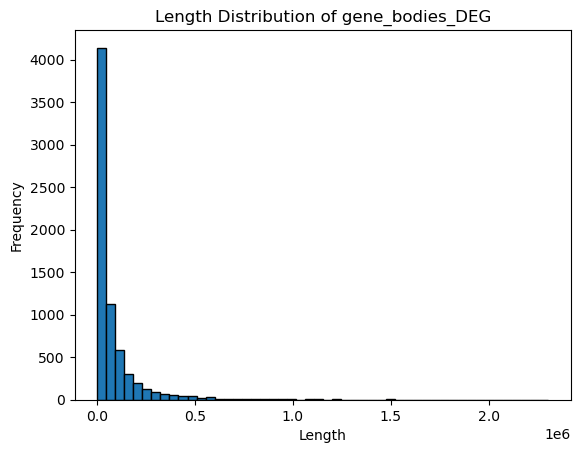

In [43]:
# Assuming 'length' is the column with the lengths
lengths = gene_bodies_DEG['length']

plt.hist(lengths, bins=50, edgecolor='black')
plt.title('Length Distribution of gene_bodies_DEG')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

### WGBS_tools

#### NB

In [44]:
# Call the function
folder = "/data/lvisser/wgbs_tools/outputs/segmentations/NB_only/unfiltered"
wgbs_seg_nb = process_wgbs_seg_files(folder)
wgbs_seg_nb = find_annot_overlap(wgbs_seg_nb, rf_promotors_genes)
wgbs_seg_nb.to_csv("/data/lvisser/feature_matrices/wgbs_seg_nb.csv", index = False)

In [45]:
wgbs_seg_nb = pd.read_csv("/data/lvisser/feature_matrices/wgbs_seg_nb.csv")
print(wgbs_seg_nb.shape)
wgbs_seg_nb.head()

(1824180, 15)


,chrom,start,end,startCpG,endCpG,SHP12dec_R4,SHY2sept_R1,IMR14nov_R1,SKN14nov_R2,IMR21nov_R2,SKN21nov_R3,SHY10nov_R2,SHP17nov_R2,segment_id,gene_symbol
0,chr22,10510235,10512049,27218094,27218104,0.04,0.04,0.88,0.06,0.00,0.92,0.00,0.00,chr22:10510235-10512049,NaN
1,chr22,10513853,10515736,27218105,27218120,0.02,0.08,0.92,0.07,0.00,1.00,0.04,0.00,chr22:10513853-10515736,NaN
2,chr22,10516017,10517750,27218120,27218125,0.15,0.00,1.00,0.00,0.00,1.00,0.00,0.00,chr22:10516017-10517750,NaN
3,chr22,10518304,10520219,27218125,27218137,0.00,0.00,1.00,0.09,0.14,0.98,0.05,0.03,chr22:10518304-10520219,NaN
4,chr22,10520752,10522650,27218139,27218150,0.11,0.00,NaN,0.06,NaN,NaN,0.00,0.00,chr22:10520752-10522650,NaN


In [46]:
meth_seg_wgbs_nb_fm = create_fm_wgbs(wgbs_seg_nb, metadata)
meth_seg_wgbs_nb_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_nb_fm.csv", index = False)
print(meth_seg_wgbs_nb_fm.shape)
meth_seg_wgbs_nb_fm.head()

(8, 1138104)


,sample_id_adj,chr22:10510235-10512049,chr22:10513853-10515736,chr22:10516017-10517750,chr22:10518304-10520219,chr22:10522965-10524772,chr22:10525487-10525747,chr22:10525749-10526013,chr22:10526088-10526122,chr22:10526130-10526166,...,chr9:138231368-138231459,chr9:138231521-138233282,chr9:138233436-138235402,chr9:138235444-138235580,chr9:138235594-138235929,chr9:138235956-138236478,chr9:138236607-138238521,source_directory,Group,tumor_type
0,SHP12dec_R4,0.04,0.02,0.15,0.00,0.04,0.84,0.93,0.92,0.73,...,0.50,0.20,0.33,0.44,0.31,0.79,0.13,data_OHMX20230016R_20231114,S,NB
1,SHY2sept_R1,0.04,0.08,0.00,0.00,0.00,0.81,0.57,0.11,0.71,...,0.73,0.67,0.43,0.94,0.37,0.83,0.88,data_OHMX20230016R_20231114,R,NB
2,IMR14nov_R1,0.88,0.92,1.00,1.00,1.00,1.00,0.96,1.00,0.88,...,0.82,0.85,0.68,0.94,0.88,0.92,0.91,data_OHMX20230016R_20231114,S,NB
3,SKN14nov_R2,0.06,0.07,0.00,0.09,0.02,0.71,0.56,0.18,0.86,...,0.40,0.30,0.11,0.58,0.05,0.67,0.27,data_OHMX20230016R_20231114,R,NB
4,IMR21nov_R2,0.00,0.00,0.00,0.14,0.14,0.67,0.46,0.25,1.00,...,0.69,0.84,0.80,1.00,0.71,0.80,1.00,data_OHMX20230016R_NB2,S,NB


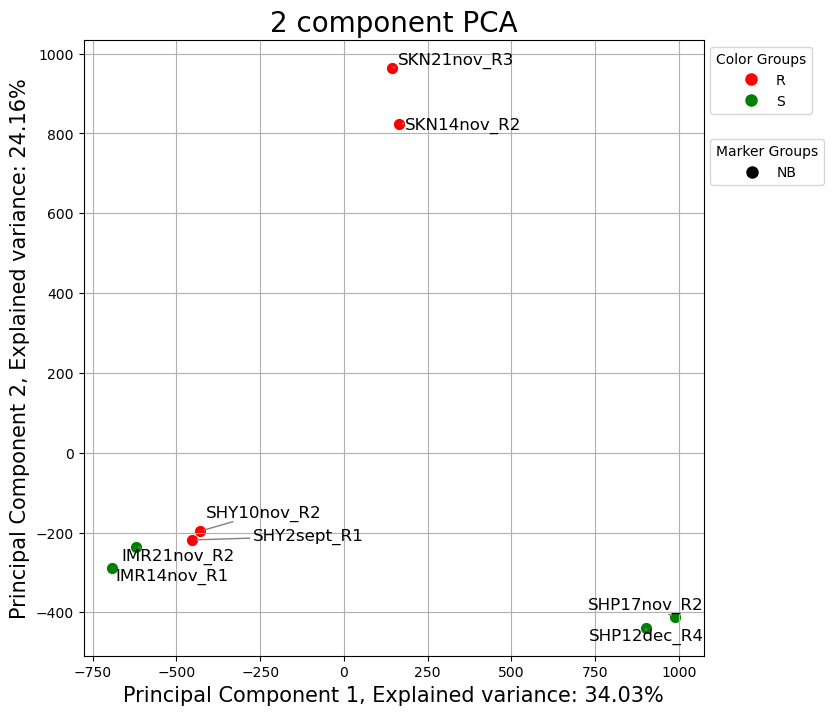

In [50]:
pca_plot(meth_seg_wgbs_nb_fm, color_column = "Group", marker_column = "tumor_type", label_column = "sample_id_adj", colors = ["r", "g"], markers = ["o"])

In [48]:
# Call the function
folder = '/data/lvisser/wgbs_tools/outputs/dmr/NB_only/unfiltered'  # replace with your folder
wgbs_dmr_nb = process_wgbs_dmr_files(folder)
wgbs_dmr_nb = find_annot_overlap(wgbs_dmr_nb, rf_promotors_genes)
wgbs_dmr_nb.to_csv("/data/lvisser/feature_matrices/wgbs_dmr_nb.csv", index = False)

In [49]:
wgbs_dmr_nb = pd.read_csv("/data/lvisser/feature_matrices/wgbs_dmr_nb.csv")
print(wgbs_dmr_nb.shape)
wgbs_dmr_nb.head()

(89987, 18)


,chrom,start,end,startCpG,endCpG,target,segment_id,lenCpG,bp,tg_mean,bg_mean,delta_means,delta_quants,delta_maxmin,ttest,direction,length,gene_symbol
0,chr8,391200,391748,12449719,12449731,R,chr8:391200-391748,12CpGs,548bp,0.0105,0.793,0.783,0.4150,0.352,0.00135,U,548,NaN
1,chr8,446137,446528,12450437,12450445,R,chr8:446137-446528,8CpGs,391bp,0.3760,0.949,0.573,0.4670,0.333,0.00863,U,391,NaN
2,chr8,641521,641944,12453264,12453284,R,chr8:641521-641944,20CpGs,423bp,0.3150,0.798,0.483,0.0918,-0.148,0.04990,U,423,NaN
3,chr8,650267,650531,12453528,12453543,R,chr8:650267-650531,15CpGs,264bp,0.3340,0.935,0.601,0.4280,0.319,0.01010,U,264,NaN
4,chr8,934441,935218,12460311,12460342,R,chr8:934441-935218,31CpGs,777bp,0.0506,0.575,0.525,0.2160,0.172,0.00355,U,777,NaN


#### MM

In [51]:
# Call the function
folder = "/data/lvisser/wgbs_tools/outputs/segmentations/MM_only/unfiltered"
wgbs_seg_mm = process_wgbs_seg_files(folder)
wgbs_seg_mm = find_annot_overlap(wgbs_seg_mm, rf_promotors_genes)
wgbs_seg_mm.to_csv("/data/lvisser/feature_matrices/wgbs_seg_mm.csv", index = False)

In [52]:
wgbs_seg_mm = pd.read_csv("/data/lvisser/feature_matrices/wgbs_seg_mm.csv")
print(wgbs_seg_mm.shape)
wgbs_seg_mm.head()

(2436165, 11)


,chrom,start,end,startCpG,endCpG,JJN3_2_1,MM1R_4_3,OPM_4_3,RPMI8226_3_3,segment_id,gene_symbol
0,chr22,10510235,10511697,27218094,27218102,0.22,0.8,NaN,1.0,chr22:10510235-10511697,NaN
1,chr22,10512833,10514603,27218104,27218110,0.30,1.0,NaN,0.9,chr22:10512833-10514603,NaN
2,chr22,10514792,10514994,27218110,27218115,NaN,NaN,NaN,NaN,chr22:10514792-10514994,NaN
3,chr22,10515170,10517014,27218115,27218124,0.25,NaN,NaN,1.0,chr22:10515170-10517014,NaN
4,chr22,10517749,10518350,27218124,27218127,NaN,NaN,NaN,NaN,chr22:10517749-10518350,NaN


In [53]:
meth_seg_wgbs_mm_fm = create_fm_wgbs(wgbs_seg_mm, metadata)
meth_seg_wgbs_mm_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_mm_fm.csv", index = False)
print(meth_seg_wgbs_mm_fm.shape)
meth_seg_wgbs_mm_fm.head()

(4, 1640061)


,sample_id_adj,chr22:10519035-10520844,chr22:10523473-10525269,chr22:10525487-10525946,chr22:10525988-10526067,chr22:10526102-10526125,chr22:10526140-10526194,chr22:10526196-10526215,chr22:10526238-10526899,chr22:10526908-10528747,...,chr9:138230113-138231335,chr9:138231458-138231709,chr9:138231832-138232715,chr9:138232777-138234470,chr9:138234559-138235402,chr9:138235579-138237577,chr9:138258705-138259649,source_directory,Group,tumor_type
0,JJN3_2_1,0.04,0.25,0.71,0.48,0.24,0.68,0.27,0.66,0.79,...,0.00,0.16,0.01,0.10,0.08,0.11,0.27,data_OHMX20230016R_MM_2,R,MM
1,MM1R_4_3,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.98,0.98,...,0.00,0.40,0.59,0.45,0.08,0.53,0.38,data_OHMX20230016R_MM_2,S,MM
2,OPM_4_3,0.00,0.30,0.58,1.00,0.25,0.78,0.12,0.46,0.44,...,0.02,0.50,0.44,0.32,0.27,0.14,0.00,data_OHMX20230016R_MM_2,S,MM
3,RPMI8226_3_3,1.00,1.00,1.00,0.97,1.00,0.90,1.00,0.98,0.99,...,0.03,0.29,0.19,0.07,0.09,0.20,0.00,data_OHMX20230016R_MM_2,R,MM


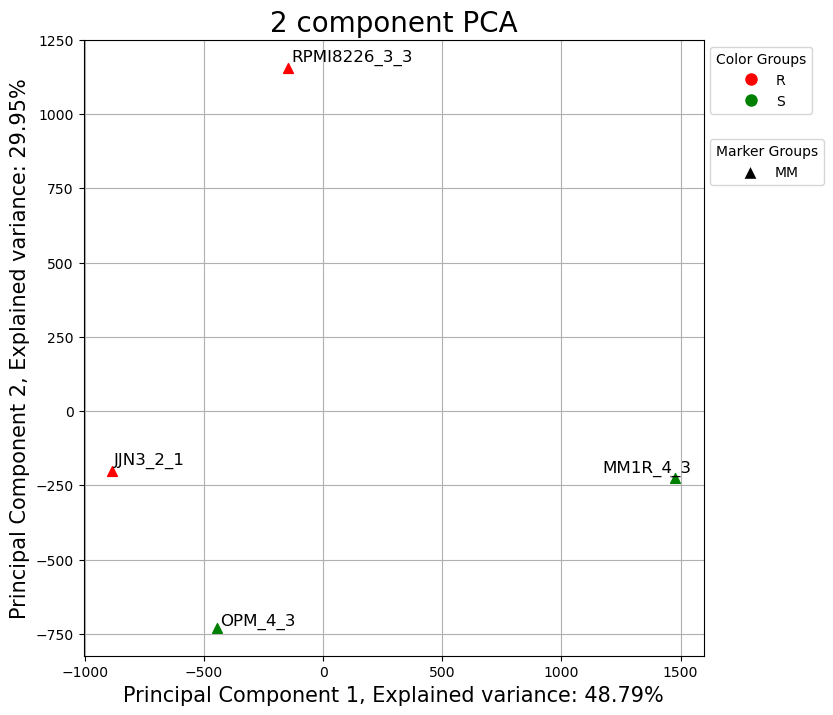

In [54]:
pca_plot(meth_seg_wgbs_mm_fm, color_column = "Group", marker_column = "tumor_type", label_column = "sample_id_adj", colors = ["r", "g"], markers = ["^"])

In [55]:
# Call the function
folder = '/data/lvisser/wgbs_tools/outputs/dmr/MM_only/unfiltered'  # replace with your folder
wgbs_dmr_mm = process_wgbs_dmr_files(folder)
wgbs_dmr_mm = find_annot_overlap(wgbs_dmr_mm, rf_promotors_genes)
wgbs_dmr_mm.to_csv("/data/lvisser/feature_matrices/wgbs_dmr_mm.csv", index = False)

In [56]:
wgbs_dmr_mm = pd.read_csv("/data/lvisser/feature_matrices/wgbs_dmr_mm.csv")
print(wgbs_dmr_mm.shape)
wgbs_dmr_mm.head()

(51158, 18)


,chrom,start,end,startCpG,endCpG,target,segment_id,lenCpG,bp,tg_mean,bg_mean,delta_means,delta_quants,delta_maxmin,ttest,direction,length,gene_symbol
0,chr8,735644,735839,12456016,12456020,R,chr8:735644-735839,4CpGs,195bp,0.0417,0.366,0.324,0.295,0.274,0.01680,U,195,NaN
1,chr8,744182,744209,12456453,12456456,R,chr8:744182-744209,3CpGs,27bp,0.3100,0.798,0.488,0.457,0.444,0.00406,U,27,NaN
2,chr8,1733185,1733229,12478474,12478479,R,chr8:1733185-1733229,5CpGs,44bp,0.2150,0.909,0.694,0.600,0.587,0.01720,U,44,NaN
3,chr8,2033622,2033665,12486006,12486011,R,chr8:2033622-2033665,5CpGs,43bp,0.6180,0.977,0.359,0.328,0.318,0.00651,U,43,NaN
4,chr8,2056508,2058050,12486478,12486516,R,chr8:2056508-2058050,38CpGs,1542bp,0.3610,0.937,0.576,0.513,0.462,0.02970,U,1542,NaN


#### Roberto

In [57]:
# Call the function
folder = "/data/lvisser/wgbs_tools/outputs/segmentations/roberto_only/unfiltered"
wgbs_seg_rob = process_wgbs_seg_files(folder)
wgbs_seg_rob = find_annot_overlap(wgbs_seg_rob, rf_promotors_genes)
wgbs_seg_rob.to_csv("/data/lvisser/feature_matrices/wgbs_seg_rob.csv", index = False)

In [58]:
wgbs_seg_rob = pd.read_csv("/data/lvisser/feature_matrices/wgbs_seg_rob.csv")
print(wgbs_seg_rob.shape)
wgbs_seg_rob.head()

(1751365, 11)


,chrom,start,end,startCpG,endCpG,SH-SY5Y_C1,SH-SY5Y_C2,SH-SY5Y_J1,SH-SY5Y_J2,segment_id,gene_symbol
0,chr22,10510235,10512049,27218094,27218104,0.14,0.03,0.03,0.00,chr22:10510235-10512049,NaN
1,chr22,10513853,10515736,27218105,27218120,0.04,0.08,0.00,0.00,chr22:10513853-10515736,NaN
2,chr22,10516385,10518350,27218122,27218127,0.12,0.00,0.00,0.06,chr22:10516385-10518350,NaN
3,chr22,10519035,10520844,27218127,27218141,0.00,0.21,0.05,0.04,chr22:10519035-10520844,NaN
4,chr22,10521531,10523474,27218142,27218153,0.04,0.03,0.06,0.00,chr22:10521531-10523474,NaN


In [59]:
meth_seg_wgbs_rob_fm = create_fm_wgbs(wgbs_seg_rob, metadata)
meth_seg_wgbs_rob_fm['Group'] = meth_seg_wgbs_rob_fm['Group'].replace('Ss', 'S')
meth_seg_wgbs_rob_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_rob_fm.csv", index = False)
print(meth_seg_wgbs_rob_fm.shape)
meth_seg_wgbs_rob_fm.head()

(4, 1506198)


,sample_id_adj,chr22:10510235-10512049,chr22:10513853-10515736,chr22:10516385-10518350,chr22:10519035-10520844,chr22:10521531-10523474,chr22:10523565-10525269,chr22:10525487-10525647,chr22:10525675-10525733,chr22:10525744-10525753,...,chr9:138235444-138235580,chr9:138235594-138235838,chr9:138235928-138236338,chr9:138236806-138238555,chr9:138243705-138245697,chr9:138257561-138259442,chr9:138303904-138305610,source_directory,Group,tumor_type
0,SH-SY5Y_C1,0.14,0.04,0.12,0.00,0.04,0.04,0.74,0.81,0.68,...,1.00,0.56,0.94,0.74,0.80,0.90,1.00,data_OHMXroberto,R,NB
1,SH-SY5Y_C2,0.03,0.08,0.00,0.21,0.03,0.08,0.81,0.86,0.57,...,0.90,0.25,0.80,0.83,0.87,0.88,0.97,data_OHMXroberto,R,NB
2,SH-SY5Y_J1,0.03,0.00,0.00,0.05,0.06,0.09,0.80,0.69,0.62,...,1.00,0.45,0.77,0.79,0.96,0.90,0.95,data_OHMXroberto,S,NB
3,SH-SY5Y_J2,0.00,0.00,0.06,0.04,0.00,0.15,0.75,0.75,0.86,...,0.94,0.14,1.00,0.92,0.94,0.93,0.96,data_OHMXroberto,S,NB


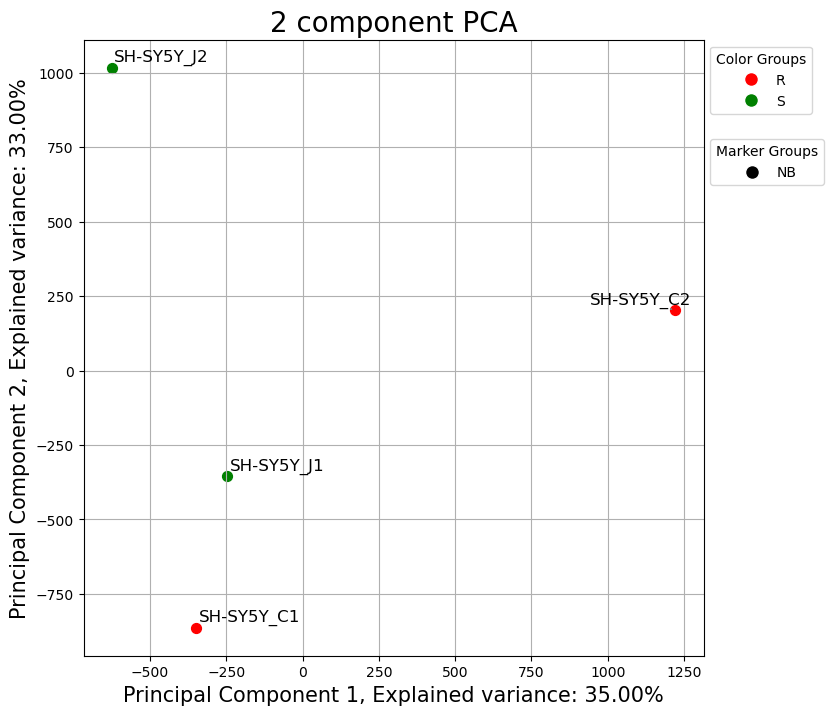

In [60]:
pca_plot(meth_seg_wgbs_rob_fm, color_column = "Group", marker_column = "tumor_type", label_column = "sample_id_adj", colors = ["r", "g"], markers = ["o"])

#### NB + MM

In [61]:
# Call the function
folder = "/data/lvisser/wgbs_tools/outputs/segmentations/NB_and_MM/unfiltered"
wgbs_seg_nbmm = process_wgbs_seg_files(folder)
wgbs_seg_nbmm = find_annot_overlap(wgbs_seg_nbmm, rf_promotors_genes)
wgbs_seg_nbmm.to_csv("/data/lvisser/feature_matrices/wgbs_seg_nbmm.csv", index = False)

In [62]:
wgbs_seg_nbmm = pd.read_csv("/data/lvisser/feature_matrices/wgbs_seg_nbmm.csv")
print(wgbs_seg_nbmm.shape)
wgbs_seg_nbmm.head()

(1918943, 19)


,chrom,start,end,startCpG,endCpG,SHP12dec_R4,SHY2sept_R1,IMR14nov_R1,SKN14nov_R2,IMR21nov_R2,SKN21nov_R3,SHY10nov_R2,SHP17nov_R2,JJN3_2_1,MM1R_4_3,RPMI8226_3_3,OPM_4_3,segment_id,gene_symbol
0,chr22,10510235,10512049,27218094,27218104,0.04,0.04,0.88,0.06,0.00,0.92,0.00,0.00,0.18,0.67,0.83,NaN,chr22:10510235-10512049,NaN
1,chr22,10513853,10515736,27218105,27218120,0.02,0.08,0.92,0.07,0.00,1.00,0.04,0.00,0.25,1.00,0.90,NaN,chr22:10513853-10515736,NaN
2,chr22,10516017,10517750,27218120,27218125,0.15,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.33,NaN,1.00,NaN,chr22:10516017-10517750,NaN
3,chr22,10518304,10520219,27218125,27218137,0.00,0.00,1.00,0.09,0.14,0.98,0.05,0.03,0.04,1.00,1.00,0.0,chr22:10518304-10520219,NaN
4,chr22,10520404,10520844,27218137,27218141,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,chr22:10520404-10520844,NaN


In [63]:
meth_seg_wgbs_nbmm_fm = create_fm_wgbs(wgbs_seg_nbmm, metadata)
meth_seg_wgbs_nbmm_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_nbmm_fm.csv", index = False)
print(meth_seg_wgbs_nbmm_fm.shape)
meth_seg_wgbs_nbmm_fm.head()

(12, 1069560)


,sample_id_adj,chr22:10518304-10520219,chr22:10523473-10525269,chr22:10525487-10525647,chr22:10525658-10525946,chr22:10525988-10526067,chr22:10526088-10526125,chr22:10526140-10526166,chr22:10526193-10526215,chr22:10526238-10528006,...,chr9:138221127-138221207,chr9:138229180-138231127,chr9:138231458-138232715,chr9:138232777-138233863,chr9:138234154-138234560,chr9:138234662-138235402,chr9:138235579-138237577,source_directory,Group,tumor_type
0,SHP12dec_R4,0.00,0.04,0.85,0.91,0.79,0.88,0.70,0.92,0.84,...,0.83,0.00,0.23,0.16,0.62,0.16,0.33,data_OHMX20230016R_20231114,S,NB
1,SHY2sept_R1,0.00,0.19,0.85,0.62,0.49,0.24,0.73,0.35,0.65,...,1.00,0.15,0.61,0.75,0.38,0.38,0.73,data_OHMX20230016R_20231114,R,NB
2,IMR14nov_R1,1.00,1.00,1.00,0.98,0.93,1.00,1.00,1.00,0.99,...,1.00,0.10,0.82,0.87,0.71,0.62,0.89,data_OHMX20230016R_20231114,S,NB
3,SKN14nov_R2,0.09,0.16,0.71,0.60,0.72,0.25,0.82,0.07,0.53,...,0.44,0.00,0.33,0.25,0.20,0.00,0.25,data_OHMX20230016R_20231114,R,NB
4,IMR21nov_R2,0.14,0.33,0.74,0.48,0.12,0.20,1.00,0.17,0.73,...,1.00,0.12,0.80,0.87,0.81,0.81,0.84,data_OHMX20230016R_NB2,S,NB


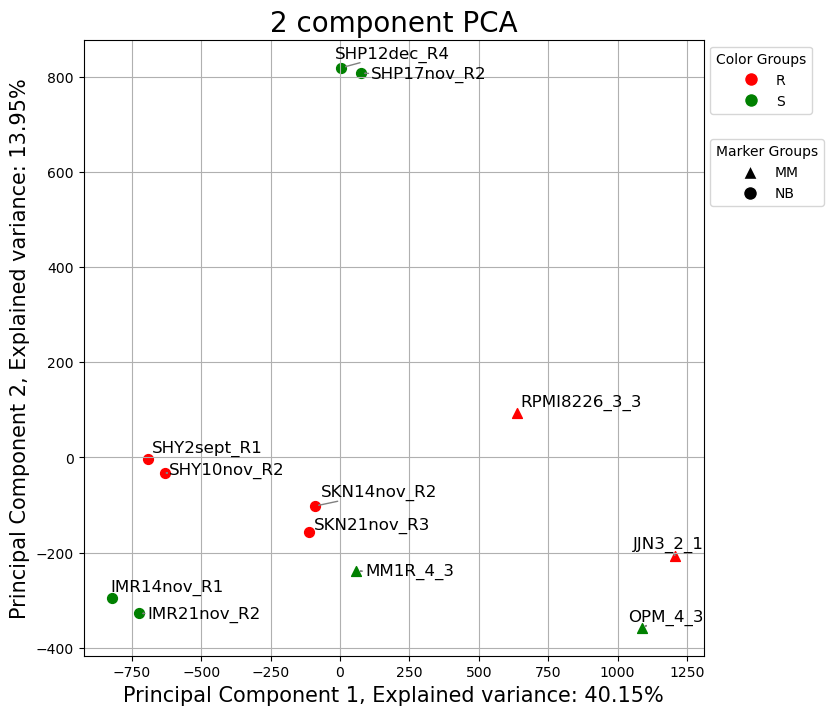

In [67]:
pca_plot(meth_seg_wgbs_nbmm_fm, color_column = "Group", marker_column = "tumor_type", label_column = "sample_id_adj", colors = ["r", "g"], markers = ["^", "o"])

#### NB + Roberto

In [68]:
# Call the function
folder = "/data/lvisser/wgbs_tools/outputs/segmentations/NB_and_roberto/unfiltered"
wgbs_seg_nbrob = process_wgbs_seg_files(folder)
wgbs_seg_nbrob = find_annot_overlap(wgbs_seg_nbrob, rf_promotors_genes)
wgbs_seg_nbrob.to_csv("/data/lvisser/feature_matrices/wgbs_seg_nbrob.csv", index = False)

In [69]:
wgbs_seg_nbrob = pd.read_csv("/data/lvisser/feature_matrices/wgbs_seg_nbrob.csv")
print(wgbs_seg_nbrob.shape)
wgbs_seg_nbrob.head()

(1761027, 19)


,chrom,start,end,startCpG,endCpG,SHP12dec_R4,SHY2sept_R1,IMR14nov_R1,SKN14nov_R2,IMR21nov_R2,SKN21nov_R3,SHY10nov_R2,SHP17nov_R2,SH-SY5Y_C2,SH-SY5Y_C1,SH-SY5Y_J1,SH-SY5Y_J2,segment_id,gene_symbol
0,chr22,10510235,10512049,27218094,27218104,0.04,0.04,0.88,0.06,0.00,0.92,0.00,0.00,0.03,0.14,0.03,0.00,chr22:10510235-10512049,NaN
1,chr22,10513853,10515736,27218105,27218120,0.02,0.08,0.92,0.07,0.00,1.00,0.04,0.00,0.08,0.04,0.00,0.00,chr22:10513853-10515736,NaN
2,chr22,10516017,10517750,27218120,27218125,0.15,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.08,0.10,0.00,0.10,chr22:10516017-10517750,NaN
3,chr22,10518304,10520219,27218125,27218137,0.00,0.00,1.00,0.09,0.14,0.98,0.05,0.03,0.20,0.00,0.04,0.04,chr22:10518304-10520219,NaN
4,chr22,10520404,10520844,27218137,27218141,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.09,0.00,chr22:10520404-10520844,NaN


In [70]:
meth_seg_wgbs_nbrob_fm = create_fm_wgbs(wgbs_seg_nbrob, metadata)
meth_seg_wgbs_nbrob_fm['Group'] = meth_seg_wgbs_nbrob_fm['Group'].replace('Ss', 'S')
meth_seg_wgbs_nbrob_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_nbrob_fm.csv", index = False)
print(meth_seg_wgbs_nbrob_fm.shape)
meth_seg_wgbs_nbrob_fm.head()

(12, 1100137)


,sample_id_adj,chr22:10510235-10512049,chr22:10513853-10515736,chr22:10516017-10517750,chr22:10518304-10520219,chr22:10521531-10523474,chr22:10523565-10525269,chr22:10525487-10525733,chr22:10525744-10526013,chr22:10526088-10526122,...,chr9:138232777-138233863,chr9:138234518-138234560,chr9:138234662-138235402,chr9:138235444-138235580,chr9:138235594-138235929,chr9:138236806-138238555,chr9:138303904-138305610,source_directory,Group,tumor_type
0,SHP12dec_R4,0.04,0.02,0.15,0.00,0.11,0.04,0.85,0.92,0.92,...,0.16,0.79,0.16,0.44,0.31,0.15,0.86,data_OHMX20230016R_20231114,S,NB
1,SHY2sept_R1,0.04,0.08,0.00,0.00,0.00,0.21,0.82,0.58,0.11,...,0.75,0.38,0.38,0.94,0.37,0.92,0.92,data_OHMX20230016R_20231114,R,NB
2,IMR14nov_R1,0.88,0.92,1.00,1.00,1.00,1.00,1.00,0.96,1.00,...,0.87,0.80,0.62,0.94,0.88,0.91,1.00,data_OHMX20230016R_20231114,S,NB
3,SKN14nov_R2,0.06,0.07,0.00,0.09,0.04,0.17,0.72,0.56,0.18,...,0.25,0.25,0.00,0.58,0.05,0.31,0.32,data_OHMX20230016R_20231114,R,NB
4,IMR21nov_R2,0.00,0.00,0.00,0.14,0.00,0.33,0.68,0.45,0.25,...,0.87,0.86,0.81,1.00,0.71,1.00,0.97,data_OHMX20230016R_NB2,S,NB


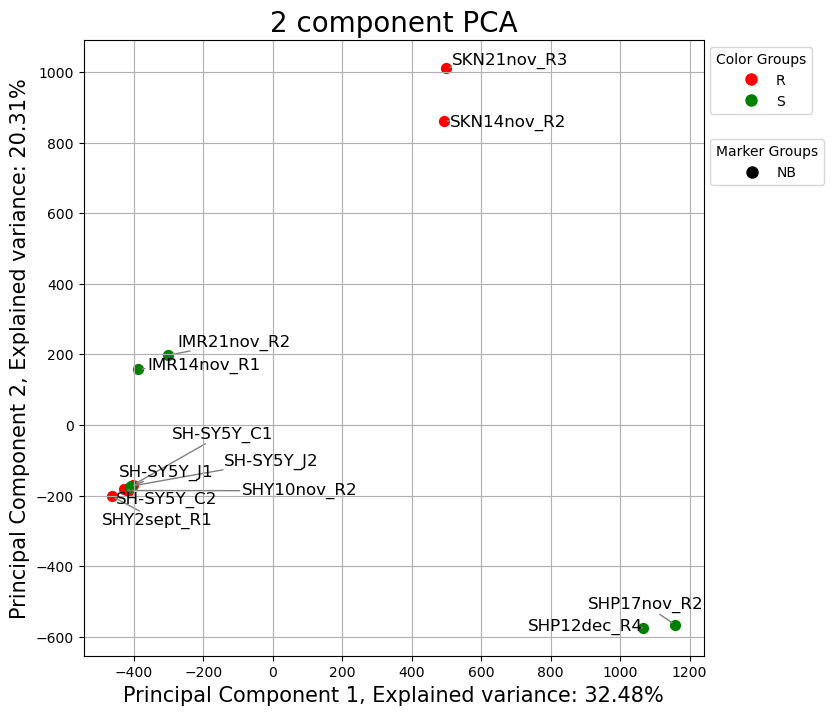

In [71]:
pca_plot(meth_seg_wgbs_nbrob_fm, color_column = "Group", marker_column = "tumor_type", label_column = "sample_id_adj", colors = ["r", "g"], markers = ["o"])

## Feature Extraction/Reduction

### Annotation-Based

#### Promotor Regions

In [88]:
cpg_promotors_df = pd.read_csv("/data/lvisser/feature_matrices/concatenated_tables/all_samples/cpg_cat_all_unicvg.csv")
print(cpg_promotors_df.shape)
cpg_promotors_df.head()

(105555914, 6)


,chrom,ref_position,source_directory,sample_id_adj,cpg_coverage,mod_qual
0,chr15,17024844,data_OHMX20230016R_20231114,IMR14nov_R1,1,0.038086
1,chr15,17024908,data_OHMX20230016R_20231114,IMR14nov_R1,2,0.989258
2,chr15,17024909,data_OHMX20230016R_20231114,IMR14nov_R1,1,0.018555
3,chr15,17024994,data_OHMX20230016R_20231114,IMR14nov_R1,10,0.306250
4,chr15,17024995,data_OHMX20230016R_20231114,IMR14nov_R1,4,0.244141


In [ ]:
rf_promotors_DEG = pd.read_csv("/data/lvisser/segmentations/rf_promotors_DEG.csv")
meth_seg_promotors = cpg2segment_aggregation_trees(cpg_promotors_df, rf_promotors_DEG[["chrom", "start", "end", "segment_id", "gene_symbol", "length"]].copy())
meth_seg_promotors.to_csv("/data/lvisser/feature_matrices/meth_seg_promotors.csv", index = False)

In [89]:
meth_seg_promotors = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_promotors.csv")
meth_seg_promotors['positions'] = meth_seg_promotors['positions'].apply(ast.literal_eval)
meth_seg_promotors['mod_qual_positions'] = meth_seg_promotors['mod_qual_positions'].apply(ast.literal_eval)
print(meth_seg_promotors.shape)
meth_seg_promotors.head()

(41456, 11)


,sample_id_adj,segment_id,source_directory,total_methylation,positions,mod_qual_positions,num_cpgs,avg_methylation,gene_symbol,length,chrom
0,SHP12dec_R4,chr10:100007200-100011200,data_OHMX20230016R_20231114,10.963867,"[100008393, 100008400, 100008481, 100009965, 1...","[0.13964844, 0.14355469, 0.0068359375, 0.26855...",52,0.210844,DNMBP,4000,chr10
1,SHY2sept_R1,chr10:100007200-100011200,data_OHMX20230016R_20231114,20.630925,"[100008392, 100008393, 100008399, 100008400, 1...","[0.9970703, 0.70214844, 0.99902344, 0.9951172,...",66,0.312590,DNMBP,4000,chr10
2,SKN14nov_R2,chr10:100007200-100011200,data_OHMX20230016R_20231114,18.848796,"[100008392, 100008393, 100008399, 100008400, 1...","[0.914550785, 0.99804687, 0.997558595, 0.99609...",46,0.409756,DNMBP,4000,chr10
3,MM1R_4_3,chr10:100007200-100011200,data_OHMX20230016R_MM_2,18.136719,"[100008400, 100009775, 100009964, 100009965, 1...","[0.9951172, 0.5390625, 0.07714844, 0.35742187,...",69,0.262851,DNMBP,4000,chr10
4,OPM_4_3,chr10:100007200-100011200,data_OHMX20230016R_MM_2,17.936523,"[100008393, 100008399, 100008400, 100008481, 1...","[0.9638672, 0.99804687, 0.85253906, 0.99902344...",45,0.398589,DNMBP,4000,chr10


In [90]:
meth_seg_promotors_fm = create_fm(meth_seg_promotors, metadata)
meth_seg_promotors_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_promotors_fm.csv", index = False)

In [91]:
meth_seg_promotors_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_promotors_fm.csv")
print(meth_seg_promotors_fm.shape)
meth_seg_promotors_fm.head()

(8, 4745)


,Group,sample_id_adj,source_directory,chr10:100007200-100011200,chr10:100183600-100187801,chr10:100266000-100268800,chr10:100284600-100287601,chr10:100345600-100351401,chr10:100745000-100746201,chr10:100968800-100972001,...,chrX:81119601-81122600,chrX:85002601-85005201,chrX:85375201-85380000,chrX:8729800-8732801,chrX:91434001-91436601,chrX:9462800-9468201,chrX:9764801-9766201,chrX:9785000-9788401,chrX:9912200-9915000,tumor_type
0,S,IMR14nov_R1,data_OHMX20230016R_20231114,0.290123,0.286979,0.669037,0.484533,0.217334,0.221267,0.221540,...,0.119683,0.131966,0.0,0.290820,0.761475,0.130469,0.942758,0.840195,0.902930,NB
1,S,SHP12dec_R4,data_OHMX20230016R_20231114,0.210844,0.279630,0.837943,0.555257,0.217633,0.805809,0.664258,...,0.038379,0.397461,0.0,0.539388,0.392643,0.422164,0.850849,0.714821,0.320457,NB
2,R,SHY2sept_R1,data_OHMX20230016R_20231114,0.312590,0.297658,0.785635,0.537883,0.248456,0.271168,0.292039,...,0.034686,0.200439,0.0,0.239757,0.357178,0.140259,0.424845,0.684925,0.363281,NB
3,R,SKN14nov_R2,data_OHMX20230016R_20231114,0.409756,0.194222,0.645020,0.392968,0.199697,0.241347,0.252734,...,0.038737,0.087416,0.0,0.206008,0.260742,0.141866,0.819221,0.630834,0.048828,NB
4,R,JJN3_2_1,data_OHMX20230016R_MM_2,0.316730,0.212823,0.528454,0.515598,0.216315,0.219263,0.316882,...,0.035156,0.145278,0.0,0.412621,0.387695,0.314923,0.684226,0.313171,0.388672,MM


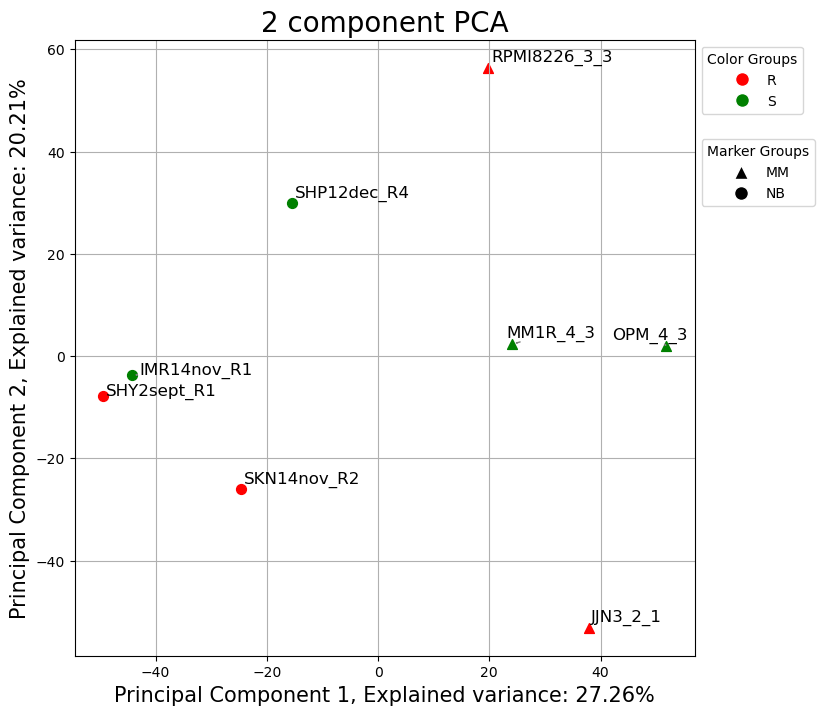

In [93]:
pca_plot(meth_seg_promotors_fm, label_column = "sample_id_adj", color_column = "Group", marker_column = "tumor_type", colors = ["r", "g"], markers = ["^", "o"])

#### Gene Bodies

In [ ]:
cpg_genebds_df = pd.read_csv("/data/lvisser/feature_matrices/concatenated_tables/all_samples/cpg_cat_all_unicvg.csv")
print(cpg_genebds_df.shape)
cpg_genebds_df.head()

In [ ]:
gene_bodies_DEG = pd.read_csv("/data/lvisser/segmentations/gene_bodies_DEG.csv")
meth_seg_genebds = cpg2segment_aggregation_trees(cpg_genebds_df, gene_bodies_DEG[["chrom", "start", "end", "segment_id", "gene_symbol", "length"]].copy())
meth_seg_genebds.to_csv("/data/lvisser/feature_matrices/meth_seg_genebds.csv", index = False)

In [94]:
meth_seg_genebds = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_genebds.csv")
meth_seg_genebds['positions'] = meth_seg_genebds['positions'].apply(ast.literal_eval)
meth_seg_genebds['mod_qual_positions'] = meth_seg_genebds['mod_qual_positions'].apply(ast.literal_eval)
print(meth_seg_genebds.shape)
meth_seg_genebds.head()

In [ ]:
meth_seg_genebds_fm = create_fm(meth_seg_genebds, metadata)
meth_seg_genebds_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_genebds_fm.csv", index = False)

In [ ]:
meth_seg_genebds_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_genebds_fm.csv")
print(meth_seg_genebds_fm.shape)
meth_seg_genebds_fm.head()

In [ ]:
pca_plot(meth_seg_genebds_fm, label_column = "sample_id_adj", color_column = "Group", marker_column = "tumor_type", colors = ["r", "g"], markers = ["^", "o"])

#### Correlation Transcription-Methylation

In [ ]:
correlations_promotors_df = tm_pcc(meth_seg_promotors, metadata, DEG_full, "/data/lvisser/tm_pcc/tm_pcc_promotors.csv")
print(correlations_promotors_df.shape)
correlations_promotors_df.head()

In [ ]:
# Call the function with your correlations DataFrame
plot_correlation_distribution(correlations_promotors_df[correlations_promotors_df["p_value"] < 0.05])

In [ ]:
plot_pvalue_distribution(correlations_promotors_df["p_value"])

In [ ]:
correlations_genebds_df = tm_pcc(meth_seg_genebds, metadata, DEG_full, "/data/lvisser/tm_pcc/tm_pcc_genebds.csv")
print(correlations_genebds_df.shape)
correlations_genebds_df.head()

In [ ]:
# Call the function with your correlations DataFrame
plot_correlation_distribution(correlations_genebds_df[correlations_genebds_df["p_value"] < 0.05])

In [ ]:
plot_pvalue_distribution(correlations_genebds_df["p_value"])

## Model Training

### Promotor Regions

In [ ]:
meth_seg_promotors_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_promotors_fm.csv")
print(meth_seg_promotors_fm.shape)
meth_seg_promotors_fm.head()

In [ ]:
meth_seg_promotors_nb_fm = meth_seg_promotors_fm[meth_seg_promotors_fm["tumor_type"] == "NB"]
meth_seg_promotors_mm_fm = meth_seg_promotors_fm[meth_seg_promotors_fm["tumor_type"] == "MM"]

#### NB

In [ ]:
train_indices = [0, 1, 2]
test_indices = [3]
name = "promotors_nb"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_promotors_nb_fm, train_indices = train_indices, test_indices = test_indices, reg = True)
save_model(model, train_indices, test_indices, name)

In [ ]:
ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:],
    feature_names=X_test.columns
)

In [ ]:
shap_promotors_nb_df = train_and_predict_loo(meth_seg_promotors_nb_fm, reg = True)
shap_promotors_nb_df_annot = find_annot_overlap(shap_promotors_nb_df, rf_promotors_genes)
shap_promotors_nb_df_annot.to_csv("/data/lvisser/shap/shap_promotors_nb_df_annot.csv", index=False)

In [ ]:
shap_promotors_nb_df = pd.read_csv("/data/lvisser/shap/shap_promotors_nb_df_annot.csv")
print(shap_promotors_nb_df_annot.shape)
shap_promotors_nb_df_annot.head()

#### MM

In [ ]:
train_indices = [0, 1, 2]
test_indices = [3]
name = "promotors_mm"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_promotors_mm_fm, train_indices = train_indices, test_indices = test_indices, reg = True)
save_model(model, train_indices, test_indices, name)

In [ ]:
ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:],
    feature_names=X_test.columns
)

In [ ]:
shap_promotors_mm_df = train_and_predict_loo(meth_seg_promotors_mm_fm, reg = True)
shap_promotors_mm_df_annot = find_annot_overlap(shap_promotors_mm_df, rf_promotors_genes)
shap_promotors_mm_df_annot.to_csv("/data/lvisser/shap/shap_promotors_mm_df_annot.csv", index=False)

In [ ]:
shap_promotors_mm_df_annot = pd.read_csv("/data/lvisser/shap/shap_promotors_mm_df_annot.csv")
print(shap_promotors_mm_df_annot.shape)
shap_promotors_mm_df_annot.head()

### Gene Bodies

In [ ]:
meth_seg_genebds_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_genebds_fm.csv")
print(meth_seg_genebds_fm.shape)
meth_seg_genebds_fm.head()

In [ ]:
meth_seg_genebds_nb_fm = meth_seg_genebds_fm[meth_seg_genebds_fm["tumor_type"] == "NB"]
meth_seg_genebds_mm_fm = meth_seg_genebds_fm[meth_seg_genebds_fm["tumor_type"] == "MM"]

#### NB

In [ ]:
train_indices = [0, 1, 2]
test_indices = [3]
name = "genebds_nb"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_genebds_nb_fm, train_indices = train_indices, test_indices = test_indices, reg = True)
save_model(model, train_indices, test_indices, name)

In [ ]:
ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:],
    feature_names=X_test.columns
)

In [ ]:
shap_genebds_nb_df = train_and_predict_loo(meth_seg_genebds_nb_fm, reg = True)
shap_genebds_nb_df_annot = find_annot_overlap(shap_genebds_nb_df, gene_bodies_105)
shap_genebds_nb_df_annot.to_csv("/data/lvisser/shap/shap_genebds_nb_df_annot.csv", index=False)

In [ ]:
shap_genebds_nb_df_annot = pd.read_csv("/data/lvisser/shap/shap_genebds_nb_df_annot.csv")
print(shap_genebds_nb_df_annot.shape)
shap_genebds_nb_df_annot.head()

#### MM

In [ ]:
train_indices = [0, 1, 2]
test_indices = [3]
name = "genebds_mm"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_genebds_mm_fm, train_indices = train_indices, test_indices = test_indices, reg = True)
save_model(model, train_indices, test_indices, name)

In [ ]:
ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:],
    feature_names=X_test.columns
)

In [ ]:
shap_genebds_mm_df = train_and_predict_loo(meth_seg_genebds_mm_fm, reg = True)
shap_genebds_mm_df_annot = find_annot_overlap(shap_genebds_mm_df, gene_bodies_105)
shap_genebds_mm_df_annot.to_csv("/data/lvisser/shap/shap_genebds_mm_df_annot.csv", index=False)

In [ ]:
shap_genebds_mm_df_annot = pd.read_csv("/data/lvisser/shap/shap_genebds_mm_df_annot.csv")
print(shap_genebds_mm_df_annot.shape)
shap_genebds_mm_df_annot.head()

### WGBS_tools

#### NB

In [72]:
print(meth_seg_wgbs_nb_fm.shape)
meth_seg_wgbs_nb_fm.head()

(8, 1138104)


,sample_id_adj,chr22:10510235-10512049,chr22:10513853-10515736,chr22:10516017-10517750,chr22:10518304-10520219,chr22:10522965-10524772,chr22:10525487-10525747,chr22:10525749-10526013,chr22:10526088-10526122,chr22:10526130-10526166,...,chr9:138231368-138231459,chr9:138231521-138233282,chr9:138233436-138235402,chr9:138235444-138235580,chr9:138235594-138235929,chr9:138235956-138236478,chr9:138236607-138238521,source_directory,Group,tumor_type
0,SHP12dec_R4,0.04,0.02,0.15,0.00,0.04,0.84,0.93,0.92,0.73,...,0.50,0.20,0.33,0.44,0.31,0.79,0.13,data_OHMX20230016R_20231114,S,NB
1,SHY2sept_R1,0.04,0.08,0.00,0.00,0.00,0.81,0.57,0.11,0.71,...,0.73,0.67,0.43,0.94,0.37,0.83,0.88,data_OHMX20230016R_20231114,R,NB
2,IMR14nov_R1,0.88,0.92,1.00,1.00,1.00,1.00,0.96,1.00,0.88,...,0.82,0.85,0.68,0.94,0.88,0.92,0.91,data_OHMX20230016R_20231114,S,NB
3,SKN14nov_R2,0.06,0.07,0.00,0.09,0.02,0.71,0.56,0.18,0.86,...,0.40,0.30,0.11,0.58,0.05,0.67,0.27,data_OHMX20230016R_20231114,R,NB
4,IMR21nov_R2,0.00,0.00,0.00,0.14,0.14,0.67,0.46,0.25,1.00,...,0.69,0.84,0.80,1.00,0.71,0.80,1.00,data_OHMX20230016R_NB2,S,NB


DMR has removed 1090274 features of the original 1138100.
Regularization has removed 40741 features of the original 47826.
Sample: 0
Cell line: IMR21nov_R2
True label: S (1)
Predicted label: S (1)
Probabilities:
['R']: 0.38969317083065247
['S']: 0.6103068291693475

Sample: 1
Cell line: SKN21nov_R3
True label: R (0)
Predicted label: S (1)
Probabilities:
['R']: 0.3168417652713017
['S']: 0.6831582347286983

Sample: 2
Cell line: SHY10nov_R2
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.8035969561559427
['S']: 0.19640304384405727

Sample: 3
Cell line: SHP17nov_R2
True label: S (1)
Predicted label: S (1)
Probabilities:
['R']: 0.3641843538428924
['S']: 0.6358156461571076



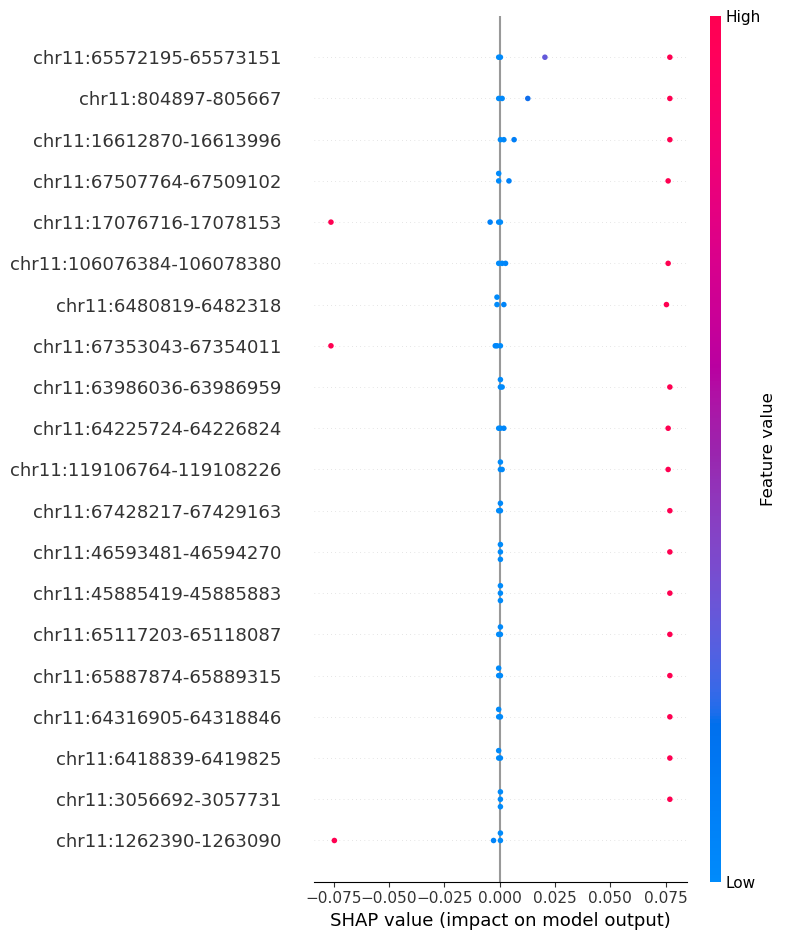

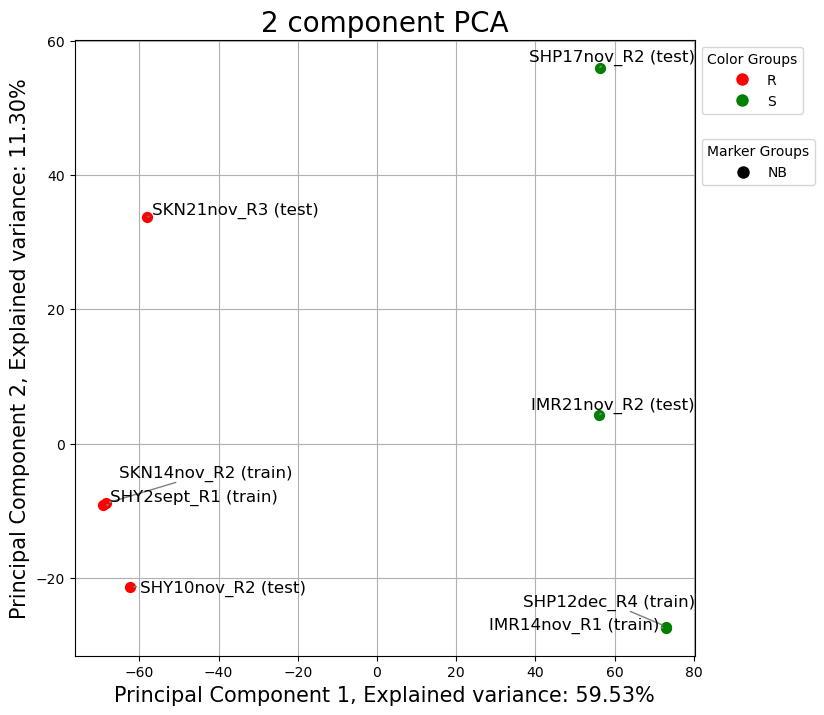

In [81]:
train_indices = [0, 1, 2, 3]
test_indices = [4, 5, 6, 7]
name = "wgbs_nb"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_wgbs_nb_fm, train_indices = train_indices, test_indices = test_indices, reg = True, dmr = "ttest")
save_model(model, train_indices, test_indices, name)

In [278]:
shap_wgbs_nb_df = train_and_predict_loo(meth_seg_wgbs_nb_fm, reg = True, dmr = "ttest")
shap_wgbs_nb_df_annot = find_annot_overlap(shap_wgbs_nb_df, rf_promotors_genes)
shap_wgbs_nb_df_annot.to_csv("/data/lvisser/shap/shap_wgbs_nb_df_annot.csv", index=False)

/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Average accuracy: 1.0


In [279]:
shap_wgbs_nb_df_annot = pd.read_csv("/data/lvisser/shap/shap_wgbs_nb_df_annot.csv")
print(shap_wgbs_nb_df_annot.shape)
shap_wgbs_nb_df_annot.head()

(16947, 10)


,segment_id,average_shap_value,reliability_shap_value,shap_variance,z_score,avg_meth_R,avg_meth_S,diff,direction,gene_symbol
0,chr17:44004488-44005412,-0.000041,0.000888,7.977185e-07,3.299747,0.0225,0.8775,-0.8550,U,PYY
1,chr7:103653969-103655849,-0.000042,0.000887,7.971323e-07,3.294967,0.9275,0.0000,0.9275,M,NaN
2,chr5:112707358-112708326,-0.000044,0.000886,7.880595e-07,3.289421,0.0000,0.0100,-0.0100,U,APC
3,chr20:18566919-18568007,-0.000044,0.000886,7.880595e-07,3.289421,0.0000,0.0100,-0.0100,U,LINC00493
4,chr1:45583287-45585281,-0.000044,0.000886,7.880595e-07,3.289421,0.0000,0.0100,-0.0100,U,NASP


#### MM

In [280]:
print(meth_seg_wgbs_mm_fm.shape)
meth_seg_wgbs_mm_fm.head()

(4, 1640061)


,sample_id_adj,chr22:10519035-10520844,chr22:10523473-10525269,chr22:10525487-10525946,chr22:10525988-10526067,chr22:10526102-10526125,chr22:10526140-10526194,chr22:10526196-10526215,chr22:10526238-10526899,chr22:10526908-10528747,...,chr9:138230113-138231335,chr9:138231458-138231709,chr9:138231832-138232715,chr9:138232777-138234470,chr9:138234559-138235402,chr9:138235579-138237577,chr9:138258705-138259649,source_directory,Group,tumor_type
0,JJN3_2_1,0.04,0.25,0.71,0.48,0.24,0.68,0.27,0.66,0.79,...,0.00,0.16,0.01,0.10,0.08,0.11,0.27,data_OHMX20230016R_MM_2,R,MM
1,MM1R_4_3,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.98,0.98,...,0.00,0.40,0.59,0.45,0.08,0.53,0.38,data_OHMX20230016R_MM_2,S,MM
2,OPM_4_3,0.00,0.30,0.58,1.00,0.25,0.78,0.12,0.46,0.44,...,0.02,0.50,0.44,0.32,0.27,0.14,0.00,data_OHMX20230016R_MM_2,S,MM
3,RPMI8226_3_3,1.00,1.00,1.00,0.97,1.00,0.90,1.00,0.98,0.99,...,0.03,0.29,0.19,0.07,0.09,0.20,0.00,data_OHMX20230016R_MM_2,R,MM


DMR has removed 1557280 features of the original 1640057.
Regularization has removed 26658 features of the original 82777.
Sample: 0
Cell line: RPMI8226_3_3
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.9456068077571952
['S']: 0.054393192242804804



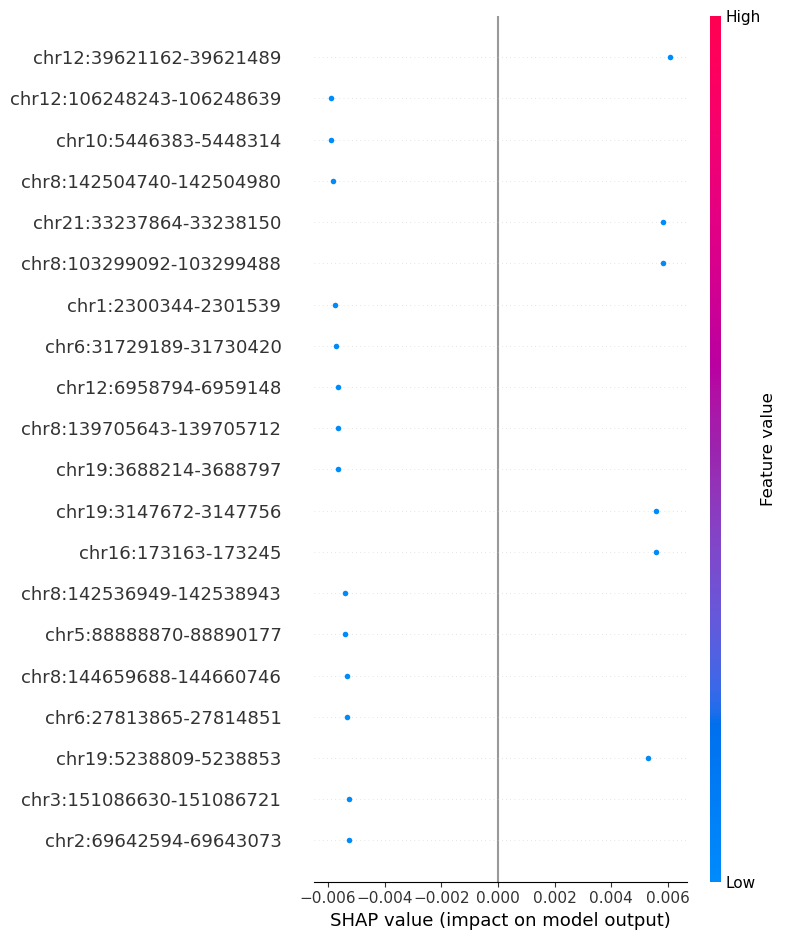

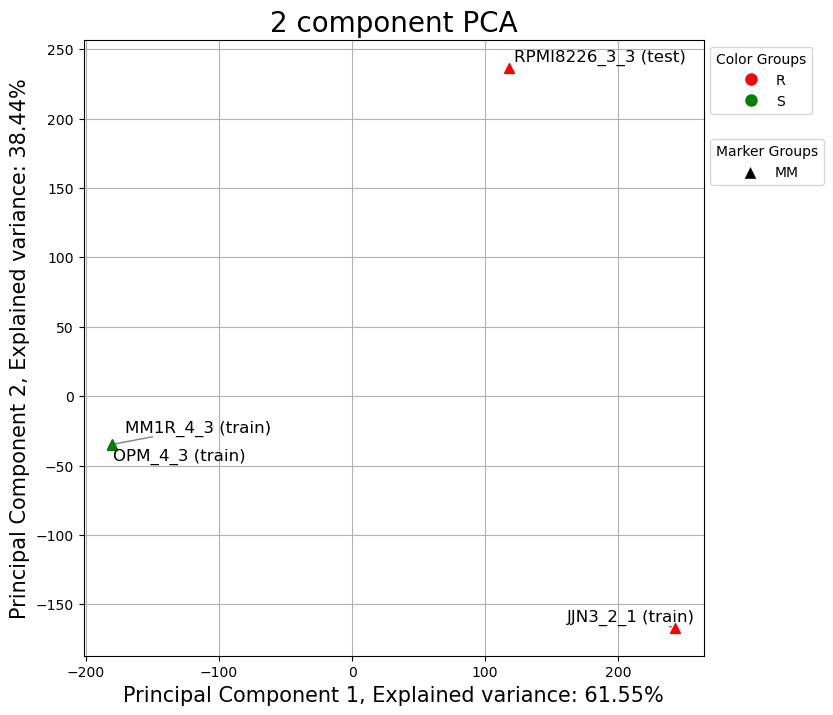

In [82]:
train_indices = [0, 1, 2]
test_indices = [3]
name = "wgbs_mm"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_wgbs_mm_fm, train_indices = train_indices, test_indices = test_indices, reg = True, dmr = "ttest")
save_model(model, train_indices, test_indices, name)

In [282]:
shap_wgbs_mm_df = train_and_predict_loo(meth_seg_wgbs_mm_fm, reg = True, dmr = "ttest")
shap_wgbs_mm_df_annot = find_annot_overlap(shap_wgbs_mm_df, rf_promotors_genes)
shap_wgbs_mm_df_annot.to_csv("/data/lvisser/shap/shap_wgbs_mm_df_annot.csv", index=False)

/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Average accuracy: 1.0


In [283]:
shap_wgbs_mm_df_annot = pd.read_csv("/data/lvisser/shap/shap_wgbs_mm_df_annot.csv")
print(shap_wgbs_mm_df_annot.shape)
shap_wgbs_mm_df_annot.head()

(159261, 10)


,segment_id,average_shap_value,reliability_shap_value,shap_variance,z_score,avg_meth_R,avg_meth_S,diff,direction,gene_symbol
0,chr12:106248243-106248639,-0.001467,0.001467,0.000009,20.951163,0.475,0.0,0.475,M,CKAP4
1,chr10:5446383-5448314,-0.001467,0.001467,0.000009,20.951163,0.475,0.0,0.475,M,NET1
2,chr8:142504740-142504980,-0.001451,0.001451,0.000009,20.724072,0.470,0.0,0.470,M,NaN
3,chr1:2300344-2301539,-0.001436,0.001436,0.000008,20.496982,0.465,0.0,0.465,M,NaN
4,chr6:31729189-31730420,-0.001420,0.001420,0.000008,20.269892,0.460,0.0,0.460,M,DDAH2


#### Roberto

In [284]:
print(meth_seg_wgbs_rob_fm.shape)
meth_seg_wgbs_rob_fm.head()

(4, 1506198)


,sample_id_adj,chr22:10510235-10512049,chr22:10513853-10515736,chr22:10516385-10518350,chr22:10519035-10520844,chr22:10521531-10523474,chr22:10523565-10525269,chr22:10525487-10525647,chr22:10525675-10525733,chr22:10525744-10525753,...,chr9:138235444-138235580,chr9:138235594-138235838,chr9:138235928-138236338,chr9:138236806-138238555,chr9:138243705-138245697,chr9:138257561-138259442,chr9:138303904-138305610,source_directory,Group,tumor_type
0,SH-SY5Y_C1,0.14,0.04,0.12,0.00,0.04,0.04,0.74,0.81,0.68,...,1.00,0.56,0.94,0.74,0.80,0.90,1.00,data_OHMXroberto,R,NB
1,SH-SY5Y_C2,0.03,0.08,0.00,0.21,0.03,0.08,0.81,0.86,0.57,...,0.90,0.25,0.80,0.83,0.87,0.88,0.97,data_OHMXroberto,R,NB
2,SH-SY5Y_J1,0.03,0.00,0.00,0.05,0.06,0.09,0.80,0.69,0.62,...,1.00,0.45,0.77,0.79,0.96,0.90,0.95,data_OHMXroberto,S,NB
3,SH-SY5Y_J2,0.00,0.00,0.06,0.04,0.00,0.15,0.75,0.75,0.86,...,0.94,0.14,1.00,0.92,0.94,0.93,0.96,data_OHMXroberto,S,NB


DMR has removed 1388098 features of the original 1506194.
Regularization has removed 16410 features of the original 118096.
Sample: 0
Cell line: SH-SY5Y_J2
True label: S (1)
Predicted label: S (1)
Probabilities:
['R']: 0.3919947826307
['S']: 0.6080052173693



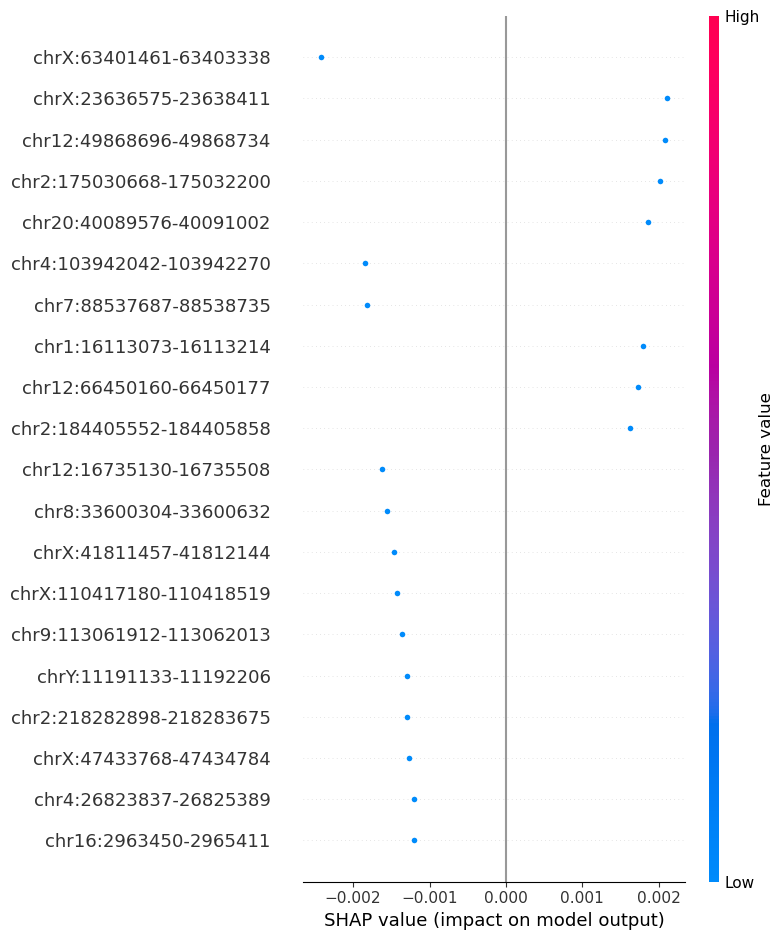

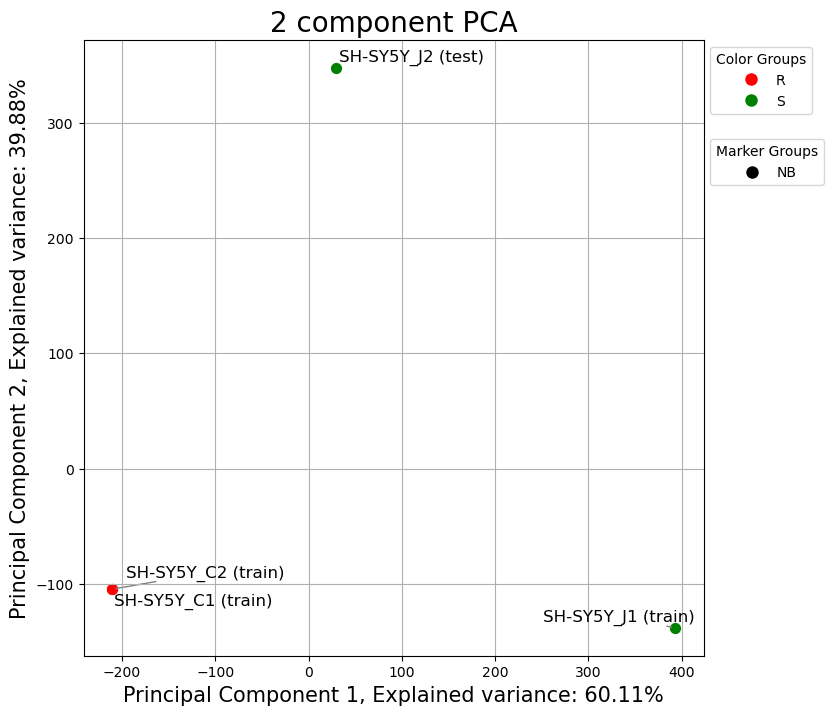

In [83]:
train_indices = [0, 1, 2]
test_indices = [3]
name = "wgbs_rob"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_wgbs_rob_fm, train_indices = train_indices, test_indices = test_indices, reg = True, dmr = "ttest")
save_model(model, train_indices, test_indices, name)

In [286]:
shap_wgbs_rob_df = train_and_predict_loo(meth_seg_wgbs_rob_fm, reg = True, dmr = "ttest")
shap_wgbs_rob_df_annot = find_annot_overlap(shap_wgbs_rob_df, rf_promotors_genes)
shap_wgbs_rob_df_annot.to_csv("/data/lvisser/shap/shap_wgbs_rob_df_annot.csv", index=False)

/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Average accuracy: 1.0


In [287]:
shap_wgbs_rob_df_annot = pd.read_csv("/data/lvisser/shap/shap_wgbs_rob_df_annot.csv")
print(shap_wgbs_rob_df_annot.shape)
shap_wgbs_rob_df_annot.head()

(157412, 10)


,segment_id,average_shap_value,reliability_shap_value,shap_variance,z_score,avg_meth_R,avg_meth_S,diff,direction,gene_symbol
0,chr3:43690481-43692137,-0.000774,0.000774,0.000002,17.402898,0.505,0.0,0.505,M,ABHD5
1,chr3:170221851-170223442,-0.000774,0.000774,0.000002,17.402898,0.505,0.0,0.505,M,PRKCI
2,chr3:46975970-46977076,-0.000774,0.000774,0.000002,17.402898,0.505,0.0,0.505,M,NaN
3,chr3:46488698-46489053,-0.000774,0.000774,0.000002,17.402898,0.505,0.0,0.505,M,NaN
4,chr3:46199260-46200959,-0.000774,0.000774,0.000002,17.402898,0.505,0.0,0.505,M,NaN


#### NB + MM

In [288]:
print(meth_seg_wgbs_nbmm_fm.shape)
meth_seg_wgbs_nbmm_fm.head()

(12, 1069560)


,sample_id_adj,chr22:10518304-10520219,chr22:10523473-10525269,chr22:10525487-10525647,chr22:10525658-10525946,chr22:10525988-10526067,chr22:10526088-10526125,chr22:10526140-10526166,chr22:10526193-10526215,chr22:10526238-10528006,...,chr9:138221127-138221207,chr9:138229180-138231127,chr9:138231458-138232715,chr9:138232777-138233863,chr9:138234154-138234560,chr9:138234662-138235402,chr9:138235579-138237577,source_directory,Group,tumor_type
0,SHP12dec_R4,0.00,0.04,0.85,0.91,0.79,0.88,0.70,0.92,0.84,...,0.83,0.00,0.23,0.16,0.62,0.16,0.33,data_OHMX20230016R_20231114,S,NB
1,SHY2sept_R1,0.00,0.19,0.85,0.62,0.49,0.24,0.73,0.35,0.65,...,1.00,0.15,0.61,0.75,0.38,0.38,0.73,data_OHMX20230016R_20231114,R,NB
2,IMR14nov_R1,1.00,1.00,1.00,0.98,0.93,1.00,1.00,1.00,0.99,...,1.00,0.10,0.82,0.87,0.71,0.62,0.89,data_OHMX20230016R_20231114,S,NB
3,SKN14nov_R2,0.09,0.16,0.71,0.60,0.72,0.25,0.82,0.07,0.53,...,0.44,0.00,0.33,0.25,0.20,0.00,0.25,data_OHMX20230016R_20231114,R,NB
4,IMR21nov_R2,0.14,0.33,0.74,0.48,0.12,0.20,1.00,0.17,0.73,...,1.00,0.12,0.80,0.87,0.81,0.81,0.84,data_OHMX20230016R_NB2,S,NB


Train: NB

Test: MM

DMR has removed 977352 features of the original 1069556.
Regularization has removed 86655 features of the original 92204.
Sample: 0
Cell line: JJN3_2_1
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.8501555128154623
['S']: 0.14984448718453772

Sample: 1
Cell line: MM1R_4_3
True label: S (1)
Predicted label: S (1)
Probabilities:
['R']: 0.29600540343659554
['S']: 0.7039945965634045

Sample: 2
Cell line: RPMI8226_3_3
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.6870097345153261
['S']: 0.31299026548467396

Sample: 3
Cell line: OPM_4_3
True label: S (1)
Predicted label: R (0)
Probabilities:
['R']: 0.725540201866609
['S']: 0.27445979813339105



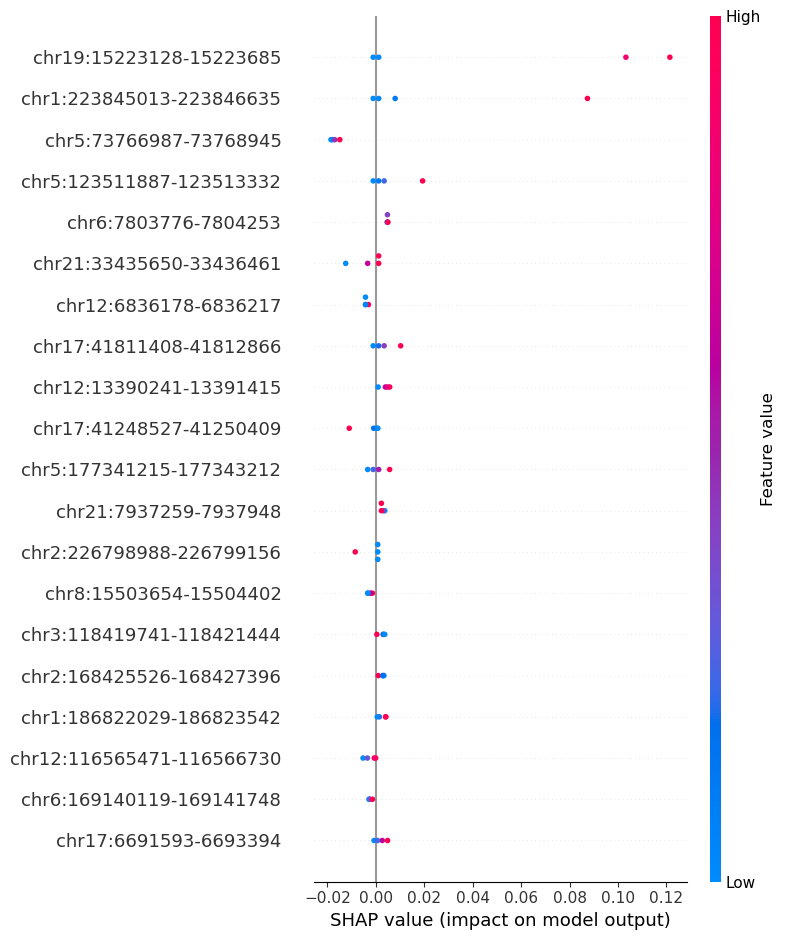

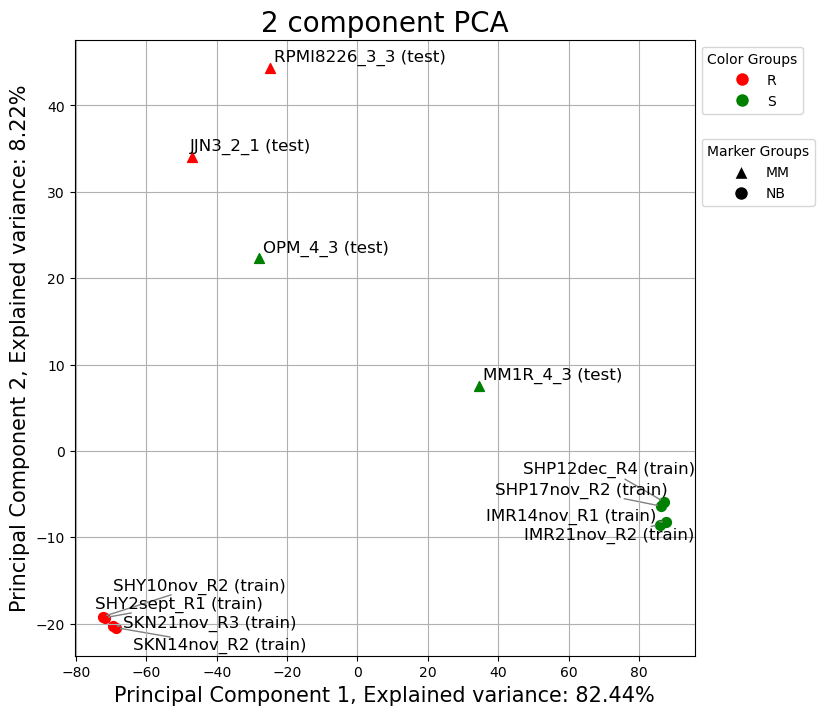

In [84]:
train_indices = [0, 1, 2, 3, 4, 5, 6, 7]
test_indices = [8, 9, 10, 11]
name = "wgbs_nbmm"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_wgbs_nbmm_fm, train_indices = train_indices, test_indices = test_indices, reg = True, dmr = "ttest")
save_model(model, train_indices, test_indices, name)

Train: MM

Test: NB

DMR has removed 1018196 features of the original 1069556.
Regularization has removed 44472 features of the original 51360.
Sample: 0
Cell line: SHP12dec_R4
True label: S (1)
Predicted label: R (0)
Probabilities:
['R']: 0.6032792763432429
['S']: 0.3967207236567572

Sample: 1
Cell line: SHY2sept_R1
True label: R (0)
Predicted label: S (1)
Probabilities:
['R']: 0.26835841025582874
['S']: 0.7316415897441713

Sample: 2
Cell line: IMR14nov_R1
True label: S (1)
Predicted label: S (1)
Probabilities:
['R']: 0.0844805970020468
['S']: 0.9155194029979532

Sample: 3
Cell line: SKN14nov_R2
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.5093267734523972
['S']: 0.49067322654760287

Sample: 4
Cell line: IMR21nov_R2
True label: S (1)
Predicted label: S (1)
Probabilities:
['R']: 0.10175140360634127
['S']: 0.8982485963936587

Sample: 5
Cell line: SKN21nov_R3
True label: R (0)
Predicted label: S (1)
Probabilities:
['R']: 0.3575196152158433
['S']: 0.6424803847841567

Sample: 6
Cell line: S

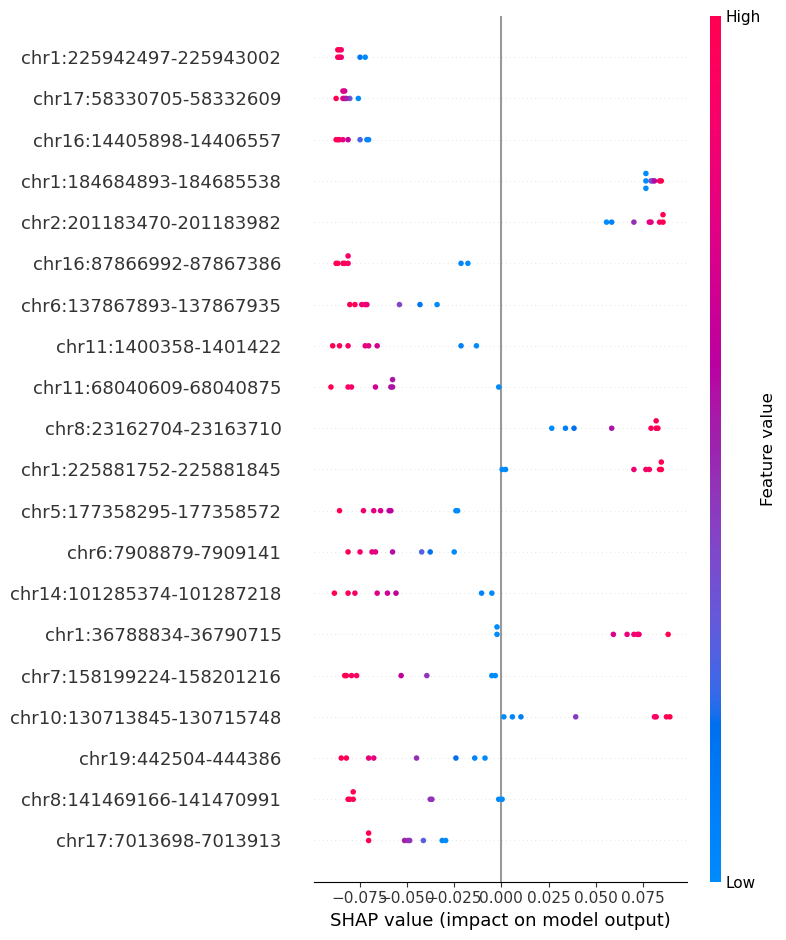

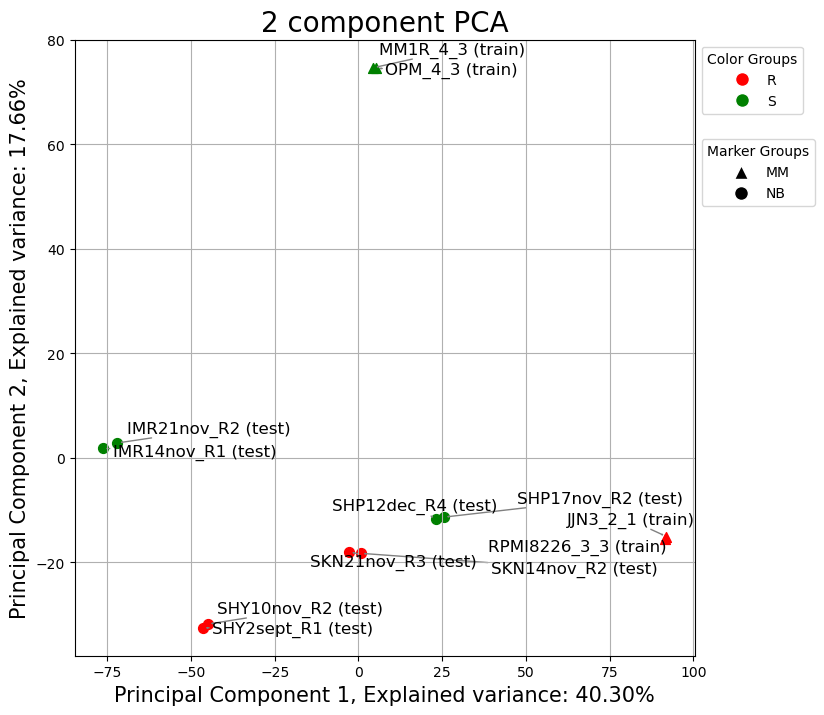

In [85]:
train_indices = [8, 9, 10, 11]
test_indices = [0, 1, 2, 3, 4, 5, 6, 7]
name = "wgbs_nbmm"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_wgbs_nbmm_fm, train_indices = train_indices, test_indices = test_indices, reg = True, dmr = "ttest")
save_model(model, train_indices, test_indices, name)

In [291]:
shap_wgbs_nbmm_df = train_and_predict_loo(meth_seg_wgbs_nbmm_fm, reg = True, dmr = "ttest")
shap_wgbs_nbmm_df_annot = find_annot_overlap(shap_wgbs_nbmm_df, rf_promotors_genes)
shap_wgbs_nbmm_df_annot.to_csv("/data/lvisser/shap/shap_wgbs_nbmm_df_annot.csv", index=False)

/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Average accuracy: 0.8333333333333334


In [292]:
shap_wgbs_nbmm_df_annot = pd.read_csv("/data/lvisser/shap/shap_wgbs_nbmm_df_annot.csv")
print(shap_wgbs_nbmm_df_annot.shape)
shap_wgbs_nbmm_df_annot.head()

(7456, 10)


,segment_id,average_shap_value,reliability_shap_value,shap_variance,z_score,avg_meth_R,avg_meth_S,diff,direction,gene_symbol
0,chr1:45583287-45585281,-0.001238,0.008539,0.000076,7.917083,0.000000,0.010000,-0.010000,U,NASP
1,chr6:130446912-130448885,-0.001124,0.008363,0.000077,7.747705,0.066667,0.826667,-0.760000,U,NaN
2,chr10:90267829-90269582,-0.001252,0.008319,0.000074,7.704994,0.071667,0.935000,-0.863333,U,NaN
3,chr5:159865440-159867133,-0.001365,0.008225,0.000073,7.615043,0.291667,0.858333,-0.566667,U,NaN
4,chr6:130337777-130339684,-0.001208,0.008180,0.000071,7.571960,0.025000,0.923333,-0.898333,U,NaN


#### NB + Roberto

In [293]:
print(meth_seg_wgbs_nbrob_fm.shape)
meth_seg_wgbs_nbrob_fm.head()

(12, 1100137)


,sample_id_adj,chr22:10510235-10512049,chr22:10513853-10515736,chr22:10516017-10517750,chr22:10518304-10520219,chr22:10521531-10523474,chr22:10523565-10525269,chr22:10525487-10525733,chr22:10525744-10526013,chr22:10526088-10526122,...,chr9:138232777-138233863,chr9:138234518-138234560,chr9:138234662-138235402,chr9:138235444-138235580,chr9:138235594-138235929,chr9:138236806-138238555,chr9:138303904-138305610,source_directory,Group,tumor_type
0,SHP12dec_R4,0.04,0.02,0.15,0.00,0.11,0.04,0.85,0.92,0.92,...,0.16,0.79,0.16,0.44,0.31,0.15,0.86,data_OHMX20230016R_20231114,S,NB
1,SHY2sept_R1,0.04,0.08,0.00,0.00,0.00,0.21,0.82,0.58,0.11,...,0.75,0.38,0.38,0.94,0.37,0.92,0.92,data_OHMX20230016R_20231114,R,NB
2,IMR14nov_R1,0.88,0.92,1.00,1.00,1.00,1.00,1.00,0.96,1.00,...,0.87,0.80,0.62,0.94,0.88,0.91,1.00,data_OHMX20230016R_20231114,S,NB
3,SKN14nov_R2,0.06,0.07,0.00,0.09,0.04,0.17,0.72,0.56,0.18,...,0.25,0.25,0.00,0.58,0.05,0.31,0.32,data_OHMX20230016R_20231114,R,NB
4,IMR21nov_R2,0.00,0.00,0.00,0.14,0.00,0.33,0.68,0.45,0.25,...,0.87,0.86,0.81,1.00,0.71,1.00,0.97,data_OHMX20230016R_NB2,S,NB


Train: NB

Test: Roberto

DMR has removed 1002730 features of the original 1100133.
Regularization has removed 91410 features of the original 97403.
Sample: 0
Cell line: SH-SY5Y_C2
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.8871390633065197
['S']: 0.11286093669348025

Sample: 1
Cell line: SH-SY5Y_C1
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.9248109674700197
['S']: 0.07518903252998033

Sample: 2
Cell line: SH-SY5Y_J1
True label: S (1)
Predicted label: R (0)
Probabilities:
['R']: 0.9261808207563853
['S']: 0.07381917924361468

Sample: 3
Cell line: SH-SY5Y_J2
True label: S (1)
Predicted label: R (0)
Probabilities:
['R']: 0.9243325447391281
['S']: 0.07566745526087192



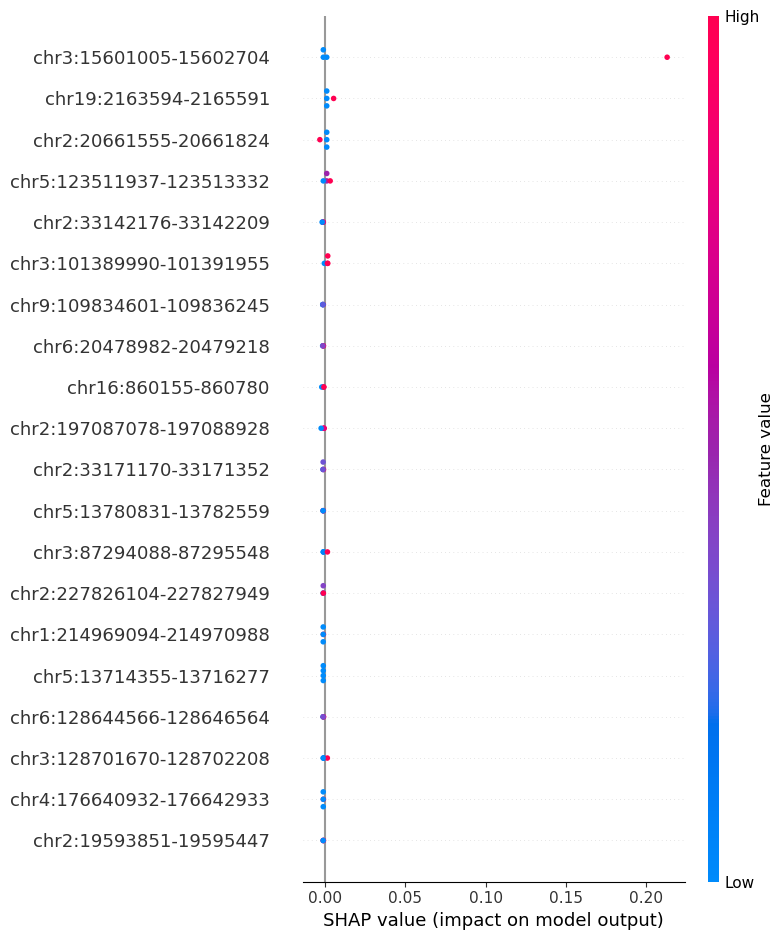

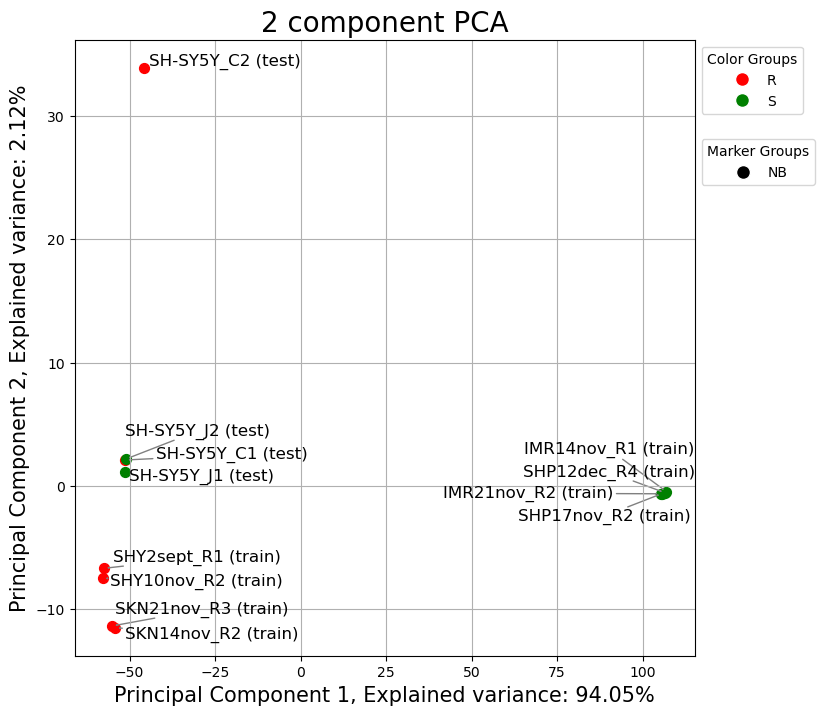

In [86]:
train_indices = [0, 1, 2, 3, 4, 5, 6, 7]
test_indices = [8, 9, 10, 11]
name = "wgbs_nbrob"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_wgbs_nbrob_fm, train_indices = train_indices, test_indices = test_indices, reg = True, dmr = "ttest")
save_model(model, train_indices, test_indices, name)

Train: Roberto

Test: NB

DMR has removed 1046993 features of the original 1100133.
Regularization has removed 45371 features of the original 53140.
Sample: 0
Cell line: SHP12dec_R4
True label: S (1)
Predicted label: R (0)
Probabilities:
['R']: 0.7448528029529196
['S']: 0.2551471970470805

Sample: 1
Cell line: SHY2sept_R1
True label: R (0)
Predicted label: S (1)
Probabilities:
['R']: 0.4640031930418813
['S']: 0.5359968069581187

Sample: 2
Cell line: IMR14nov_R1
True label: S (1)
Predicted label: R (0)
Probabilities:
['R']: 0.7565749064254803
['S']: 0.24342509357451966

Sample: 3
Cell line: SKN14nov_R2
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.8952562520053026
['S']: 0.1047437479946974

Sample: 4
Cell line: IMR21nov_R2
True label: S (1)
Predicted label: R (0)
Probabilities:
['R']: 0.8966532603398267
['S']: 0.10334673966017328

Sample: 5
Cell line: SKN21nov_R3
True label: R (0)
Predicted label: R (0)
Probabilities:
['R']: 0.8549605019788906
['S']: 0.14503949802110935

Sample: 6
Cell line: S

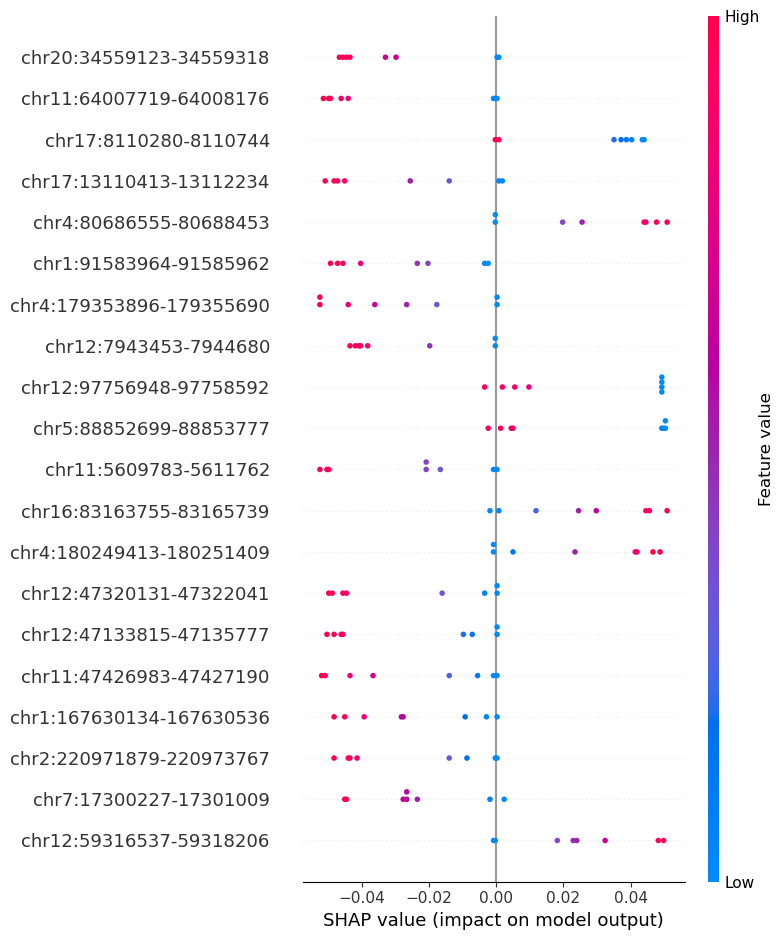

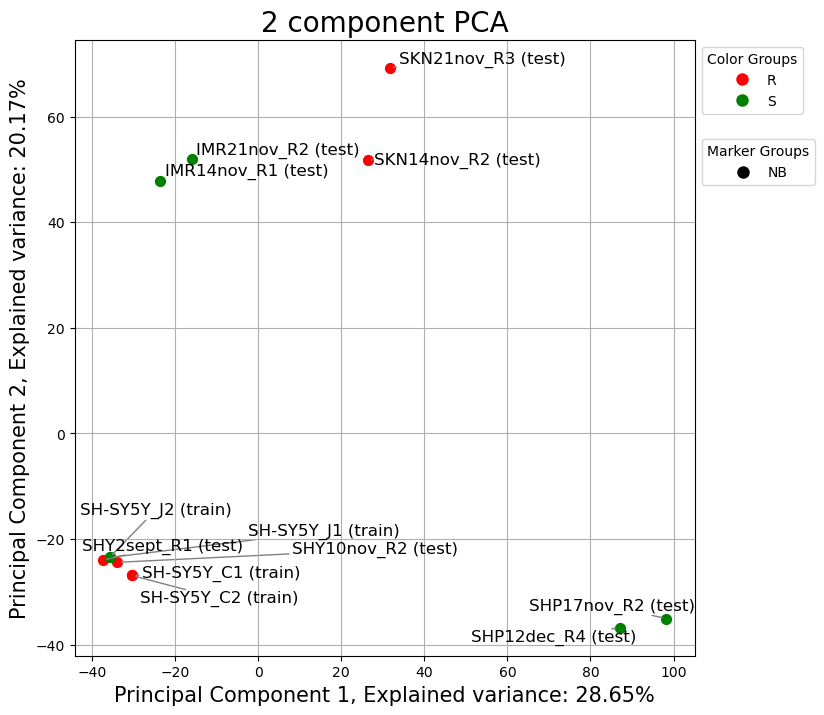

In [87]:
train_indices = [8, 9, 10, 11]
test_indices = [0, 1, 2, 3, 4, 5, 6, 7]
name = "wgbs_nbrob"
model, X_train, X_test, coeff_df, explainer, shap_values = train_and_predict_single(meth_seg_wgbs_nbrob_fm, train_indices = train_indices, test_indices = test_indices, reg = True, dmr = "ttest")
save_model(model, train_indices, test_indices, name)

In [296]:
shap_wgbs_nbrob_df = train_and_predict_loo(meth_seg_wgbs_nbrob_fm, reg = True, dmr = "ttest")
shap_wgbs_nbrob_df_annot = find_annot_overlap(shap_wgbs_nbrob_df, rf_promotors_genes)
shap_wgbs_nbrob_df_annot.to_csv("/data/lvisser/shap/shap_wgbs_nbrob_df_annot.csv", index=False)

/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Average accuracy: 0.75


In [297]:
shap_wgbs_nbrob_df_annot = pd.read_csv("/data/lvisser/shap/shap_wgbs_nbrob_df_annot.csv")
print(shap_wgbs_nbrob_df_annot.shape)
shap_wgbs_nbrob_df_annot.head()

(5917, 10)


,segment_id,average_shap_value,reliability_shap_value,shap_variance,z_score,avg_meth_R,avg_meth_S,diff,direction,gene_symbol
0,chr6:130121657-130122842,-0.001765,0.014844,0.000235,12.323478,0.243333,0.881667,-0.638333,U,NaN
1,chr18:77085540-77087259,-0.001976,0.013534,0.000202,11.223864,0.866667,0.925000,-0.058333,U,NaN
2,chr6:17988821-17988968,-0.001666,0.012874,0.000180,10.669052,0.411667,0.806667,-0.395000,U,KIF13A
3,chr15:67630902-67632892,-0.001374,0.012603,0.000173,10.442058,0.871667,0.960000,-0.088333,U,NaN
4,chr5:84850694-84852107,-0.001081,0.010964,0.000140,9.065978,0.648333,0.108333,0.540000,M,NaN
